# Статистика создания заказов мясокомбината

**Заказчик** — крупный мясокомбинат с разветвленной сетью мелкооптовых и розничных точек доставки 

**Цель Заказчика.** Выявление причин задержки сборки и доставки собранных заказов клиентам

**Цель исследования.** Выявить причины, которые создают пиковую нагрузку работы склада

**Задачи**
- Собрать и предобработать данные
- Определить зависимость времени создания заказа и ритмичности сборки заказов
- Определить зависимость срока до границы запрета заказа и ритмичности сборки заказов
- Определить зависимость скорости постановки заказа в очередь на сборку (распечатки) и ритмичности работы склада
- Определить влияние скорости сборки заказа на ритмичность работы склада
- Определить зависимость веса и стоимости заказа от времени его создания, от срока до границы запрета заказа и от времени границы запрета
- Определить зависимость границы запрета отгрузки и веса заказа от дня недели
- Выявить карту плотности распределения создания заказов
- Определить подразделения и сотрудников, формирующих заказ непосредственно перед границей запрета
- Определить сотрудников, с самым коротким интервалом между созданными заказами

**Входные данные от Заказчика.** Файлы в формате .xlsx со статистикой о товародвижении.

**Ожидаемый результат.** Выявлены закономерности, определяющие пиковую нагрузку работы склада


## Обзор данных

1. Открыть файлы 
2. Предобработать данные
3. Создать датасет для дальнейшего анализа

**Исходные данные**

- `time_zone.xlsx` - искусственно сформированных файл с указанием поправки часового пояса торгового представителя к Уральскому времени
- `bord_orders.xlsx` - табличное представление регистра сведений "Граница запрета заказов" с указанием дня недели и предельного времени подачи заказа торговым представителем
- `Отгрузки за апрель.xlsx` - группа файлов выгрузки (за каждый месяц) с указанием номера отгрузки и даты/времени каждой манипуляции с ней
- `data_orders_not_drops.xlsx` - файл выгрузки с указанием данных о заказе за указанный период (сумма, вес, дата/время каждой манипуляции)
- `data_orders_ice.xlsx` - файл выгрузки с указанием данных о заказе заморозки/полуфабрикаты за указанный период (сумма, вес, дата/время каждой манипуляции)

In [22]:
# Импотрт библиотек
import pandas as pd
import os
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import nbconvert

In [23]:
# Путь загрузки / выгрузки
job_path = 'C:\\Users\\anratoshnuk\\notebook\\orders\\'
houm_path = 'C:\\Users\\User\\first_notebook\\Разное\\Запросы Таврия\\orders\\'


#Путь загрузки данных складского движения
job_path_otgr = 'C:\\Users\\anratoshnuk\\notebook\\orders\\otgr\\'
houm_path_otgr = 'C:\\Users\\User\\first_notebook\\Разное\\Запросы Таврия\\orders\\otgr\\'


# Имена файлов загрузки
time_zone = 'time_zone.xlsx' # Поправка часового пояса торгового представителя
bord_orders = 'bord_orders.xlsx' # Граница запрета заказов
data_orders = 'data_orders_not_drops.xlsx' # Основная выгрузка с указанием данных о заказе за указанный период
data_orders_ice = 'data_orders_ice.xlsx' # Выгрузка заморозки с указанием данных о заказе за указанный период


# Имена файлов выгрузки
data_orders_csv = 'data_orders.csv' # Основной / базовый датасет


### Часовые пояса. Предобработка

In [24]:
try:
    df_time_zone = pd.read_excel(job_path + time_zone) #job
except FileNotFoundError:
    df_time_zone = pd.read_excel(houm_path + time_zone) #houm

In [25]:
df_time_zone = df_time_zone.rename(columns={'Ссылка': 'user', 'Поправка': 'time_zone_correct'})

# Убрать лишние пробелы у пользоватлелей
df_time_zone['user'] = df_time_zone['user'].apply(lambda x: " ".join(x.split()))

In [26]:
df_time_zone.head(2)

user  time_zone_correct
0  Царегородцев Александр Владимирович                 -2
1          Туркова Вероника Викторовна                  0

### Границы заказов. Предобработка

In [27]:
try:
    df_bord = pd.read_excel(job_path + bord_orders) #job
except FileNotFoundError:
    df_bord = pd.read_excel(houm_path + bord_orders) #houm

In [28]:
# Функция формализации дня недели
def num_day(day):
    if day == 'Понедельник':
        return 0
    elif day == 'Вторник':
        return 1
    elif day == 'Среда':
        return 2
    elif day == 'Четверг':
        return 3
    elif day == 'Пятница':
        return 4
    elif day == 'Суббота':
        return 5
    elif day == 'Воскресенье':
        return 6

In [29]:
df_bord['week_day'] = df_bord['День недели'].apply(num_day)

df_bord = df_bord.rename(columns={'Пользователь': 'user', 'День недели': 'day_str', 'Склад': 'stok', 'Граница запрета изменений': 'stop_bord'})

df_bord['stop_bord'] = pd.to_datetime(df_bord['stop_bord'], format='%H:%M:%S')
df_bord['stop_bord'] = df_bord['stop_bord'].dt.strftime('%H:%M')

df_bord = df_bord.drop(['day_str', 'stok'], axis=1)

df_bord = df_bord.drop_duplicates()

In [30]:
# Убрать лишние пробелы у пользоватлелей
df_bord['user'] = df_bord['user'].apply(lambda x: " ".join(x.split()))

df_bord.shape

(3632, 3)

Предполагается объединение по сочетанию двух столбцов: `user` и `week_day`. Сочетание этих столбцов содержит дубли.

Оставим только минимальные значения столбца `stop_bord`

In [31]:
df_bord.loc[df_bord['user']=='Алеева Эльза Шаукатовна'].head(4)

user stop_bord  week_day
32  Алеева Эльза Шаукатовна     16:30         4
33  Алеева Эльза Шаукатовна     18:00         4
34  Алеева Эльза Шаукатовна     16:00         2
35  Алеева Эльза Шаукатовна     18:00         2

In [32]:
# Преобразуем время запрета в дату
df_bord['stop_bord'] = pd.to_datetime(df_bord['stop_bord'], format='%H:%M')

# Проведем группировку по двум столбцам с выбором минимального значения времени
df_bord = df_bord.groupby(['user', 'week_day'])['stop_bord'].min()
df_bord = df_bord.reset_index()

# Преобразуем  Границу запрета в строку
df_bord['stop_bord'] = df_bord['stop_bord'].dt.strftime('%H:%M')

In [33]:
df_bord.loc[df_bord['user']=='Алеева Эльза Шаукатовна']

user  week_day stop_bord
28  Алеева Эльза Шаукатовна         0     18:00
29  Алеева Эльза Шаукатовна         1     17:30
30  Алеева Эльза Шаукатовна         2     16:00
31  Алеева Эльза Шаукатовна         3     17:00
32  Алеева Эльза Шаукатовна         4     16:30

In [34]:
df_bord.shape

(3441, 3)

In [35]:
df_bord.head(2)

user  week_day stop_bord
0  Абашев Владимир Азальевич         1     22:30
1  Абашев Владимир Азальевич         2     22:30

**Комментарий по дате запрета отгрузки**

День недели `week_day` соответствует  дню недели `"Даты отгрузки"` файла `"Заказы"`

Для того, чтобы выявить границу запрета отгрузки:
- •	Сопоставить  день недели `week_day` с днем недели `"Даты отгрузки"` файла `"Заказы"`
- Указать в `"Дате отгрузки"` файла `"Заказы"` время из `week_day` `"Границы запрета"`
- Вычесть 24 часа

### Сборка файлов даты печати отгрузки

In [36]:
# Создание списка файлов в директории
list_sgp = []
try:
    with os.scandir(job_path_otgr) as files:
        for file in files:
            list_sgp.append(job_path_otgr+file.name)

except FileNotFoundError:
    with os.scandir(houm_path_otgr) as files:
        for file in files:
            list_sgp.append(houm_path_otgr+file.name)

In [37]:
list_otgr = []
for i in range(len(list_sgp)):
    a = f'otgr_{i}'
    a = pd.read_excel(list_sgp[i])
    a.columns=['num', 'print_date']
    list_otgr.append(a)

In [38]:
# Объединение столбцов
df_otgr = pd.concat(list_otgr).reset_index(drop=True) 
df_otgr.shape

(249391, 2)

In [39]:
# Преобразование в дату
df_otgr['print_date'] = pd.to_datetime(df_otgr['print_date'], format='%d.%m.%Y %H:%M:%S')

# Преобразование в число
df_otgr['num'] = df_otgr['num'].astype(int)

In [40]:
df_otgr.sort_values(by=['num']).head()

num          print_date
193271  39015 2023-02-01 10:53:22
195907  42365 2023-02-02 11:26:19
192930  42400 2023-02-01 07:41:22
195290  58609 2023-02-02 08:16:58
192881  60386 2023-02-01 07:41:04

In [41]:
# Создание обобщающих столбцов
df_otgr['num_count'] = df_otgr.groupby('num')['print_date'].transform('count')
df_otgr['min_print_date'] = df_otgr.groupby('num')['print_date'].transform('min')

In [42]:
df_otgr.loc[df_otgr['num_count']>1].head()

num          print_date  num_count      min_print_date
140   320090 2023-05-15 12:48:36          2 2023-05-06 09:00:08
256   344050 2023-05-15 09:50:06          2 2023-05-15 09:50:06
3079  344050 2023-05-16 04:03:49          2 2023-05-15 09:50:06
3561  348732 2023-05-16 11:56:31          2 2023-05-16 11:56:31
3789  348732 2023-05-16 16:23:08          2 2023-05-16 11:56:31

In [43]:
# Удаление лишних столбцов, а затем - дубликатов
df_otgr = df_otgr.drop(['print_date', 'num_count'], axis=1)
df_otgr = df_otgr.drop_duplicates().reset_index(drop=True)

In [44]:
df_otgr = df_otgr.rename(columns={'num': 'id_stok', 'min_print_date': 'date_stok_print'})

In [45]:
df_otgr.shape

(248607, 2)

In [46]:
df_otgr.head(2)

id_stok     date_stok_print
0   344057 2023-05-15 09:50:42
1   344061 2023-05-15 09:50:49

### Товародвижение. Предобработка

In [47]:
try:
    df_orders_1 = pd.read_excel(job_path + data_orders) #job
except FileNotFoundError:
    df_orders_1 = pd.read_excel(houm_path + data_orders) #houm


In [48]:
df_orders_1.shape

(192697, 10)

In [49]:
df_orders_1.head(2)

Дата ДатаОтгрузки                   Ответственный  \
0  05.02.2023 13:31:06   06.02.2023       Зарипова Дарья Викторовна   
1  05.02.2023 13:31:07   07.02.2023  Тимофеева Елизавета Викторовна   

                            ОтветственныйОтделПродаж         ДатаМелафона  \
0                    Отдел продаж Курортное (Озерск)  05.02.2023 13:23:50   
1  Отдел продаж Свердловская область Восток (Асбест)  05.02.2023 13:16:34   

   СуммаДокумента ДатаПоследнегоИзменения  ВесЗаказа  НомерОтгрузки  \
0        15355.48      06.02.2023 0:38:13      39.86          81370   
1         3508.50      06.02.2023 9:06:50      13.05          81371   

               Маршрут  
0            *** Касли  
1  *** Юргамыш-Мишкино

In [50]:
try:
    df_orders_2 = pd.read_excel(job_path + data_orders_ice) #job
except FileNotFoundError:
    df_orders_2 = pd.read_excel(houm_path + data_orders_ice) #houm


In [51]:
df_orders_2.shape

(8291, 10)

In [52]:
df_orders_2.head(2)

Дата ДатаОтгрузки             Ответственный  \
0  17.05.2023 12:09:06   18.05.2023  Щипанов Сергей Борисович   
1  28.05.2023 15:53:24   29.05.2023    Реймер Анна Сергеевна    

          ОтветственныйОтделПродаж         ДатаМелафона  СуммаДокумента  \
0  Отдел продаж Курортное (Озерск)  17.05.2023 12:02:41            5650   
1         Отдел продаж Новосибирск  28.05.2023 17:45:18            2200   

  ДатаПоследнегоИзменения  ВесЗаказа  НомерОтгрузки                  Маршрут  
0     17.05.2023 12:12:38       15.0         352166                *** Тюбук  
1     28.05.2023 16:02:38        5.0         383666  *** Новосибирск Главный

In [53]:
# Объединение файлов
df_orders = pd.concat([df_orders_1, df_orders_2]).reset_index(drop=True)

In [54]:
df_orders.shape

(200988, 10)

In [55]:
df_orders.head(2)

Дата ДатаОтгрузки                   Ответственный  \
0  05.02.2023 13:31:06   06.02.2023       Зарипова Дарья Викторовна   
1  05.02.2023 13:31:07   07.02.2023  Тимофеева Елизавета Викторовна   

                            ОтветственныйОтделПродаж         ДатаМелафона  \
0                    Отдел продаж Курортное (Озерск)  05.02.2023 13:23:50   
1  Отдел продаж Свердловская область Восток (Асбест)  05.02.2023 13:16:34   

   СуммаДокумента ДатаПоследнегоИзменения  ВесЗаказа  НомерОтгрузки  \
0        15355.48      06.02.2023 0:38:13      39.86          81370   
1         3508.50      06.02.2023 9:06:50      13.05          81371   

               Маршрут  
0            *** Касли  
1  *** Юргамыш-Мишкино

In [56]:
# Промежуточная запись датасета
try:
    df_orders.to_csv(job_path + data_orders_csv) #job
except OSError:
    df_orders.to_csv(houm_path + data_orders_csv) #houm


### Предобработка файла заказов

In [57]:
# Выгрузка записанного датасета

try:
    df_orders = pd.read_csv(job_path + data_orders_csv) #job
except FileNotFoundError:
    df_orders = pd.read_csv(houm_path + data_orders_csv) #houm

In [58]:
df_orders.isna().sum()

Unnamed: 0                    0
Дата                          0
ДатаОтгрузки                  0
Ответственный                 0
ОтветственныйОтделПродаж    542
ДатаМелафона                  0
СуммаДокумента                0
ДатаПоследнегоИзменения      55
ВесЗаказа                     0
НомерОтгрузки                 0
Маршрут                       0
dtype: int64

In [59]:
# Удалим пропуски в столбце "дата последнего изменения"
df_orders = df_orders.dropna(subset='ДатаПоследнегоИзменения')

- перименование столбцов
- преобразование столбцов времени в дату
- удаление пропусков
- добавление столбца с номером дня неделе (пн=0, вс=6)
- приведение времени Мелафона к часовому поясу Урала 
- указание времени Мелафона и УПП в формате "час"
- указать разницу между заказом в КПК и поступлением в УПП
- указать разницу между заказом в УПП и отгрузкой на СГП
- средняя цена товара в заказе 

In [60]:
df_orders = df_orders.drop('Unnamed: 0', axis=1)

df_orders.shape

(200933, 10)

In [61]:
df_orders.head(3)

Дата ДатаОтгрузки                   Ответственный  \
0  05.02.2023 13:31:06   06.02.2023       Зарипова Дарья Викторовна   
1  05.02.2023 13:31:07   07.02.2023  Тимофеева Елизавета Викторовна   
2  05.02.2023 13:31:14   06.02.2023      Кузницына Ирина Викторовна   

                            ОтветственныйОтделПродаж         ДатаМелафона  \
0                    Отдел продаж Курортное (Озерск)  05.02.2023 13:23:50   
1  Отдел продаж Свердловская область Восток (Асбест)  05.02.2023 13:16:34   
2           Отдел продаж Средний Урал (Нижний Тагил)  05.02.2023 12:57:17   

   СуммаДокумента ДатаПоследнегоИзменения  ВесЗаказа  НомерОтгрузки  \
0        15355.48      06.02.2023 0:38:13      39.86          81370   
1         3508.50      06.02.2023 9:06:50      13.05          81371   
2         3421.50     05.02.2023 13:53:45       6.40          81372   

               Маршрут  
0            *** Касли  
1  *** Юргамыш-Мишкино  
2    *** Североуральск

In [62]:
# переименование столбцов

df_orders = df_orders.rename(columns={
    'Дата': 'date_chel',
    'ДатаОтгрузки': 'date_stok_plan',
    'Ответственный': 'user',
    'ОтветственныйОтделПродаж': 'region',
    'ДатаМелафона': 'date_melafon',
    'СуммаДокумента': 'total',
    'ДатаПоследнегоИзменения': 'date_stok_ok',
    'ВесЗаказа': 'weight',
    'НомерОтгрузки': 'id_stok',
    'Маршрут': 'way'
})

# Убрать лишние пробелы у пользоватлелей
df_orders['user'] = df_orders['user'].apply(lambda x: " ".join(x.split()))

 **Указание времени распечатки заказа на складе**
 
 - Добавить столбец из таблицы df_otgr
 - Пропуски заменить на произвольный символ
 - Произвольный символ заменить на дату поступления заказа из УПП

In [63]:
# Функция замены (Предварительно требуется замена пропусков на строку 'abc')
def date_stok_chenge(date_stok_print, date_stok_ok):
    if date_stok_print!='abc':
        return date_stok_print
    return date_stok_ok

In [64]:
# Добавление столбца со временем распечатки заказа на складе
df_orders = df_orders.merge(df_otgr, on='id_stok', how='left')

In [65]:
# преобразование столбцов времени в дату
df_orders['date_chel'] = pd.to_datetime(df_orders['date_chel'], format='%d.%m.%Y %H:%M:%S')
df_orders['date_stok_plan'] = pd.to_datetime(df_orders['date_stok_plan'], format='%d.%m.%Y')
df_orders['date_melafon'] = pd.to_datetime(df_orders['date_melafon'], format='%d.%m.%Y %H:%M:%S')
df_orders['date_stok_ok'] = pd.to_datetime(df_orders['date_stok_ok'], format='%d.%m.%Y %H:%M:%S')

In [66]:
# Пропуски заменить на произвольный символ
df_orders['date_stok_print'] = df_orders['date_stok_print'].fillna('abc')

# Произвольный символ заменить на дату поступления заказа из УПП
df_orders['date_stok_print_full'] = df_orders.apply(lambda x: date_stok_chenge(x['date_stok_print'], x['date_stok_ok']), axis=1)

In [67]:
# Заменим столбцы
df_orders = df_orders.drop('date_stok_print', axis=1)
df_orders = df_orders.rename(columns={'date_stok_print_full': 'date_stok_print'})

In [68]:
# преобразование столбцов сумма и вес в число

df_orders['total'] = df_orders['total'].astype(str)
df_orders['total'] = df_orders['total'].apply(lambda x: x.replace(',', '.'))
df_orders['total'] = df_orders['total'].apply(lambda x: ''.join(x.split()))
df_orders['total'] = df_orders['total'].astype(float)

df_orders['weight'] = df_orders['weight'].astype(str)
df_orders['weight'] = df_orders['weight'].apply(lambda x: x.replace(',', '.'))
df_orders['weight'] = df_orders['weight'].apply(lambda x: ''.join(x.split()))
df_orders['weight'] = df_orders['weight'].astype(float)

In [69]:
# удаление пропусков
df_orders["region"] = df_orders["region"].fillna(0)

# добавление столбца с номером дня неделе (пн=0, вс=6)
df_orders['week_day_orders'] = df_orders['date_chel'].dt.weekday
df_orders['week_day'] = df_orders['date_stok_plan'].dt.weekday
df_orders['week_day_stok'] = df_orders['date_stok_ok'].dt.weekday

In [70]:
# Функция корректировки часового пояса

def new_time(date_melafon, time_zone_correct):
    return date_melafon + timedelta(hours=time_zone_correct)

In [71]:
# Приведение времени КПК к времени УПП (Уральское время)
df_orders = df_orders.merge(df_time_zone, on='user', how='left')
df_orders['date_melafon_ural'] = df_orders.apply(lambda x: new_time(x['date_melafon'], x['time_zone_correct']), axis=1)

# добавление столбца с номером дня неделе (пн=0, вс=6)
df_orders['week_day_melafon'] = df_orders['date_melafon_ural'].dt.weekday

In [72]:
# указание времени КПК и УПП в формате "час"
df_orders['hour_date_chel'] = df_orders['date_chel'].dt.ceil('1H').dt.strftime('%H').astype(int)
df_orders['hour_melafon_ural'] = df_orders['date_melafon_ural'].dt.ceil('1H').dt.strftime('%H').astype(int)
df_orders['hour_date_stok'] = df_orders['date_stok_ok'].dt.ceil('1H').dt.strftime('%H').astype(int)

In [73]:
# функция расчета интервала в минутах
# если разница отрицательная, то возвращается 0

def fly_min(date_fin, date_start):
    fly_min = date_fin - date_start
    if int(fly_min.total_seconds()//60) < 0:
        return 0
    return int(fly_min.total_seconds()//60)

In [74]:
# разница между заказом в КПК и поступлением в УПП
# разница между заказом УПП и распечаткой сборки на СГП
# разница между распечаткой сборки на СГП и непосредственно сборкой заказа на СГП

df_orders['fly_min'] = df_orders.apply(lambda x: fly_min(x['date_chel'], x['date_melafon_ural']), axis=1)
df_orders['print_min'] = df_orders.apply(lambda x: fly_min(x['date_stok_print'], x['date_chel']), axis=1)
df_orders['making_min'] = df_orders.apply(lambda x: fly_min(x['date_stok_ok'], x['date_stok_print']), axis=1)

# средняя цена товара в заказе
df_orders['price'] = df_orders['total'] / df_orders['weight']
df_orders['price'] = round(df_orders['price'], 2)

In [75]:
df_orders.head(2)

date_chel date_stok_plan                            user  \
0 2023-02-05 13:31:06     2023-02-06       Зарипова Дарья Викторовна   
1 2023-02-05 13:31:07     2023-02-07  Тимофеева Елизавета Викторовна   

                                              region        date_melafon  \
0                    Отдел продаж Курортное (Озерск) 2023-02-05 13:23:50   
1  Отдел продаж Свердловская область Восток (Асбест) 2023-02-05 13:16:34   

      total        date_stok_ok  weight  id_stok                  way  ...  \
0  15355.48 2023-02-06 00:38:13   39.86    81370            *** Касли  ...   
1   3508.50 2023-02-06 09:06:50   13.05    81371  *** Юргамыш-Мишкино  ...   

  time_zone_correct   date_melafon_ural  week_day_melafon  hour_date_chel  \
0                 0 2023-02-05 13:23:50                 6              14   
1                 0 2023-02-05 13:16:34                 6              14   

   hour_melafon_ural hour_date_stok  fly_min  print_min  making_min   price  
0                 14              1        7        627          39  385.24  
1                 14             10       14       1113          62  268.85  

[2 rows x 24 columns]

In [76]:
df_orders.shape

(200933, 24)

### Добавление границы запретов

In [77]:
df_orders = df_orders.merge(df_bord, on=['week_day', 'user'], how='left')

In [78]:
df_orders.head(2)

date_chel date_stok_plan                            user  \
0 2023-02-05 13:31:06     2023-02-06       Зарипова Дарья Викторовна   
1 2023-02-05 13:31:07     2023-02-07  Тимофеева Елизавета Викторовна   

                                              region        date_melafon  \
0                    Отдел продаж Курортное (Озерск) 2023-02-05 13:23:50   
1  Отдел продаж Свердловская область Восток (Асбест) 2023-02-05 13:16:34   

      total        date_stok_ok  weight  id_stok                  way  ...  \
0  15355.48 2023-02-06 00:38:13   39.86    81370            *** Касли  ...   
1   3508.50 2023-02-06 09:06:50   13.05    81371  *** Юргамыш-Мишкино  ...   

    date_melafon_ural  week_day_melafon  hour_date_chel  hour_melafon_ural  \
0 2023-02-05 13:23:50                 6              14                 14   
1 2023-02-05 13:16:34                 6              14                 14   

   hour_date_stok fly_min  print_min  making_min   price  stop_bord  
0               1       7        627          39  385.24      23:59  
1              10      14       1113          62  268.85        NaN  

[2 rows x 25 columns]

**ВАЖНО**

Если граница пропущена, то проверить границу на предыдущую дату плана отгрузки. Решается корректировкой времени в файле границы отгрузок (на день назад)

Остальные пропуски обработать как дату заказа со временем 23:59

Сдвиг дня в файле `df_bord`

In [79]:
# Функция корректировки week_day назад
def back_step(day):
    if day == 0:
        return 6
    return day - 1

In [80]:
# Корректировка week_day назад
df_bord['week_day'] = df_bord['week_day'].apply(back_step)

df_bord = df_bord.rename(columns={'stop_bord': 'stop_cor_bord'})

In [81]:
df_bord.head(2)

user  week_day stop_cor_bord
0  Абашев Владимир Азальевич         0         22:30
1  Абашев Владимир Азальевич         1         22:30

**Повторно привяжем границу (смещенную на 1 день назад)**

In [82]:
df_orders = df_orders.merge(df_bord, on=['week_day', 'user'], how='left')

In [83]:
df_orders.head(2)

date_chel date_stok_plan                            user  \
0 2023-02-05 13:31:06     2023-02-06       Зарипова Дарья Викторовна   
1 2023-02-05 13:31:07     2023-02-07  Тимофеева Елизавета Викторовна   

                                              region        date_melafon  \
0                    Отдел продаж Курортное (Озерск) 2023-02-05 13:23:50   
1  Отдел продаж Свердловская область Восток (Асбест) 2023-02-05 13:16:34   

      total        date_stok_ok  weight  id_stok                  way  ...  \
0  15355.48 2023-02-06 00:38:13   39.86    81370            *** Касли  ...   
1   3508.50 2023-02-06 09:06:50   13.05    81371  *** Юргамыш-Мишкино  ...   

  week_day_melafon  hour_date_chel  hour_melafon_ural  hour_date_stok  \
0                6              14                 14               1   
1                6              14                 14              10   

   fly_min print_min  making_min   price  stop_bord  stop_cor_bord  
0        7       627          39  385.24      23:59          23:59  
1       14      1113          62  268.85        NaN            NaN  

[2 rows x 26 columns]

**Алгоритм выбора**

- Если в столбце stop_bord корректное значение (не пропуск), то принять значение из stop_bord
- Если в столбце stop_bord пропуск, но в столбце stop_cor_bord корректное значение (не пропуск), то принять значение из stop_cor_bord
- Если оба столбца имеют пропуски, то ввести 23:59

Предварительно требуется замена пропусков на условную строку

In [84]:
# Функция замены (Предварительно требуется замена пропусков на строку 'aaa')
def bord_chenge(stop_bord, stop_cor_bord):
    if stop_bord!='aaa':
        return stop_bord
    elif stop_cor_bord!='aaa':
        return stop_cor_bord
    return '23:59'

In [85]:
# замена пропусков на строку 'aaa'
df_orders['stop_bord'] = df_orders['stop_bord'].fillna('aaa')
df_orders['stop_cor_bord'] = df_orders['stop_cor_bord'].fillna('aaa')

# Формирование заполненного значения
df_orders['stop_bord_ok'] = df_orders.apply(lambda x: bord_chenge(x['stop_bord'], x['stop_cor_bord']), axis=1)

df_orders = df_orders.drop(['stop_bord', 'stop_cor_bord'], axis=1)
df_orders = df_orders.rename(columns={'stop_bord_ok': 'stop_bord'})

**Выявление времени границы запрета отгрузки**

- Преобразовать время границы запрета в `datetime`
- К плановой дате отгрузки прибавить время границы запрета
- Вычесть 24 часа

In [86]:
# Преообразовать время границы запрета в datetime
df_orders['stop_bord'] = pd.to_datetime(df_orders['stop_bord'], format='%H:%M')

In [87]:
# Функция расчета времени границы запрета отгрузки

def bord_orders(date_stok_plan, stop_bord):
    return date_stok_plan + timedelta(hours=stop_bord.hour) + timedelta(minutes=stop_bord.minute) - timedelta(hours=24)

In [88]:
# Выявление времени границы запрета отгрузки
df_orders['time_bord'] = df_orders.apply(lambda x: bord_orders(x['date_stok_plan'], x['stop_bord']), axis=1)
df_orders['stop_bord'] = df_orders['stop_bord'].dt.strftime('%H:%M')

In [89]:
# Расчет разницы Времени заказа в КПК до границы отгрузки
# Расчет разницы Времени заказа в УПП до границы отгрузки

df_orders['phon_to_bord'] = df_orders.apply(lambda x: fly_min(x['time_bord'], x['date_melafon_ural']), axis=1)
df_orders['stok_to_bord'] = df_orders.apply(lambda x: fly_min(x['time_bord'], x['date_chel']), axis=1)


In [90]:
# Удалить week_day - день недели планируемой даты отгрузки

df_orders = df_orders.drop(['week_day'], axis=1)

In [91]:
# Формирование правильного порядка столбцов

df_orders = df_orders.reindex(columns=[
    'id_stok', 'region', 'user', 'weight', 'total', 'price', 'date_melafon', 'time_zone_correct', 
    'date_melafon_ural', 'date_chel', 'date_stok_plan', 'date_stok_print', 'date_stok_ok', 
    'stop_bord', 'time_bord', 'week_day_melafon', 'week_day_orders', 'week_day_stok', 
    'hour_melafon_ural', 'hour_date_chel', 'hour_date_stok',
     'fly_min', 'print_min', 'making_min', 'phon_to_bord', 'stok_to_bord', 'way'
])

In [92]:
df_orders.shape

(200933, 27)

In [93]:
df_orders.head(2)

id_stok                                             region  \
0    81370                    Отдел продаж Курортное (Озерск)   
1    81371  Отдел продаж Свердловская область Восток (Асбест)   

                             user  weight     total   price  \
0       Зарипова Дарья Викторовна   39.86  15355.48  385.24   
1  Тимофеева Елизавета Викторовна   13.05   3508.50  268.85   

         date_melafon  time_zone_correct   date_melafon_ural  \
0 2023-02-05 13:23:50                  0 2023-02-05 13:23:50   
1 2023-02-05 13:16:34                  0 2023-02-05 13:16:34   

            date_chel  ... week_day_stok hour_melafon_ural hour_date_chel  \
0 2023-02-05 13:31:06  ...             0                14             14   
1 2023-02-05 13:31:07  ...             0                14             14   

  hour_date_stok fly_min  print_min  making_min  phon_to_bord  stok_to_bord  \
0              1       7        627          39           635           627   
1             10      14       1113          62          2082          2067   

                   way  
0            *** Касли  
1  *** Юргамыш-Мишкино  

[2 rows x 27 columns]

### Описание столбцов

- `id_stok` - номер отгрузки
- `region` – отдел продаж
- `user` – ФИО менеджера (инициатор заказа)
- `weight` – вес заказа
- `total` – стоимость заказа
- `price` – цена одного кг в заказе
- `date_melafon` – дата/время отправки заказа из КПК по времени менеджера
- `time_zone_correct` - размер корректировки к Уральскому времени (час)
- `date_melafon_ural` - дата/время отправки заказа из Мелафона по Уральскому времени
- `date_chel` - дата/время поступления заказа в УПП
- `date_stok_plan` – планируемая дата отгрузки (указывает менеджер в заказе)
- `date_stok_print` - дата/время  распечатки сборки заказа на складе
- `date_stok_ok` - дата/время  фактической сборки заказа на складе
- `stop_bord` - нормативное время стоп отгрузки
- `time_bord` – время границы запрета заказа
- `week_day_melafon` – день недели отправки заказа из КПК
- `week_day_orders` – день недели поступления заказа в УПП
- `week_day_stok` - день недели сборки заказа на складе 
- `hour_melafon_ural` – час отправки заказа из КПК по Уральскому времени
- `hour_date_chel` - час  поступления заказа в УПП
- `hour_date_stok` - час фактической сборки заказа на складе
- `fly_min` – время в минутах между отправкой заказа из КПК и поступлением его в УПП
- `print_min` - время в минутах между поступлением заказа в УПП и его распечаткой на складе
- `making_min` - время в минутах между распечаткой заказа и его сборкой на складе
- `phon_to_bord` – время в минутах от отправки заказа из КПК до границы запрета
- `stok_to_bord` – время в минутах от поступления заказа в УПП до границы запрета
- `way` - маршрут


In [94]:
# Финальная запись датасета
try:
    df_orders.to_csv(job_path + data_orders_csv) #job
except OSError:
    df_orders.to_csv(houm_path + data_orders_csv) #houm


## Группировка и визуализация

In [95]:
try:
    df_orders = pd.read_csv(job_path + data_orders_csv) #job
except FileNotFoundError:
    df_orders = pd.read_csv(houm_path + data_orders_csv) #houm

In [96]:
# Добавим стобец со значением целого часа границы запрета заказа
df_orders['time_bord'] = pd.to_datetime(df_orders['time_bord'], format='%Y-%m-%d %H:%M:%S')
df_orders['hour_bord'] = df_orders['time_bord'].dt.ceil('1H').dt.strftime('%H').astype(int)

In [97]:
df_orders['date_chel'] = pd.to_datetime(df_orders['date_chel'], format='%Y-%m-%d %H:%M:%S')
df_orders['moumth_date_chel'] = df_orders['date_chel'].dt.month

In [98]:
# Функция деления время на 15-минутные интервалы
def fifteen_min(number):
    a = round(number/60, 2) - number//60
    if a < 0.25:
        return 0.25 + number//60
    elif a < 0.5:
        return 0.5 + number//60
    elif a < 0.75:
        return 0.75 + number//60
    else:
        return 1 + number//60

In [99]:
# Добавим стобец со значением пятнадцатиминутного интервала до границы запрета заказа
df_orders['phon_to_bord_interv'] = df_orders['phon_to_bord'].apply(fifteen_min)

In [100]:
wd = ['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс']

array([[<Axes: title={'center': 'Unnamed: 0'}>,
        <Axes: title={'center': 'id_stok'}>,
        <Axes: title={'center': 'weight'}>,
        <Axes: title={'center': 'total'}>,
        <Axes: title={'center': 'price'}>],
       [<Axes: title={'center': 'time_zone_correct'}>,
        <Axes: title={'center': 'date_chel'}>,
        <Axes: title={'center': 'time_bord'}>,
        <Axes: title={'center': 'week_day_melafon'}>,
        <Axes: title={'center': 'week_day_orders'}>],
       [<Axes: title={'center': 'week_day_stok'}>,
        <Axes: title={'center': 'hour_melafon_ural'}>,
        <Axes: title={'center': 'hour_date_chel'}>,
        <Axes: title={'center': 'hour_date_stok'}>,
        <Axes: title={'center': 'fly_min'}>],
       [<Axes: title={'center': 'print_min'}>,
        <Axes: title={'center': 'making_min'}>,
        <Axes: title={'center': 'phon_to_bord'}>,
        <Axes: title={'center': 'stok_to_bord'}>,
        <Axes: title={'center': 'hour_bord'}>],
       [<Axes: title

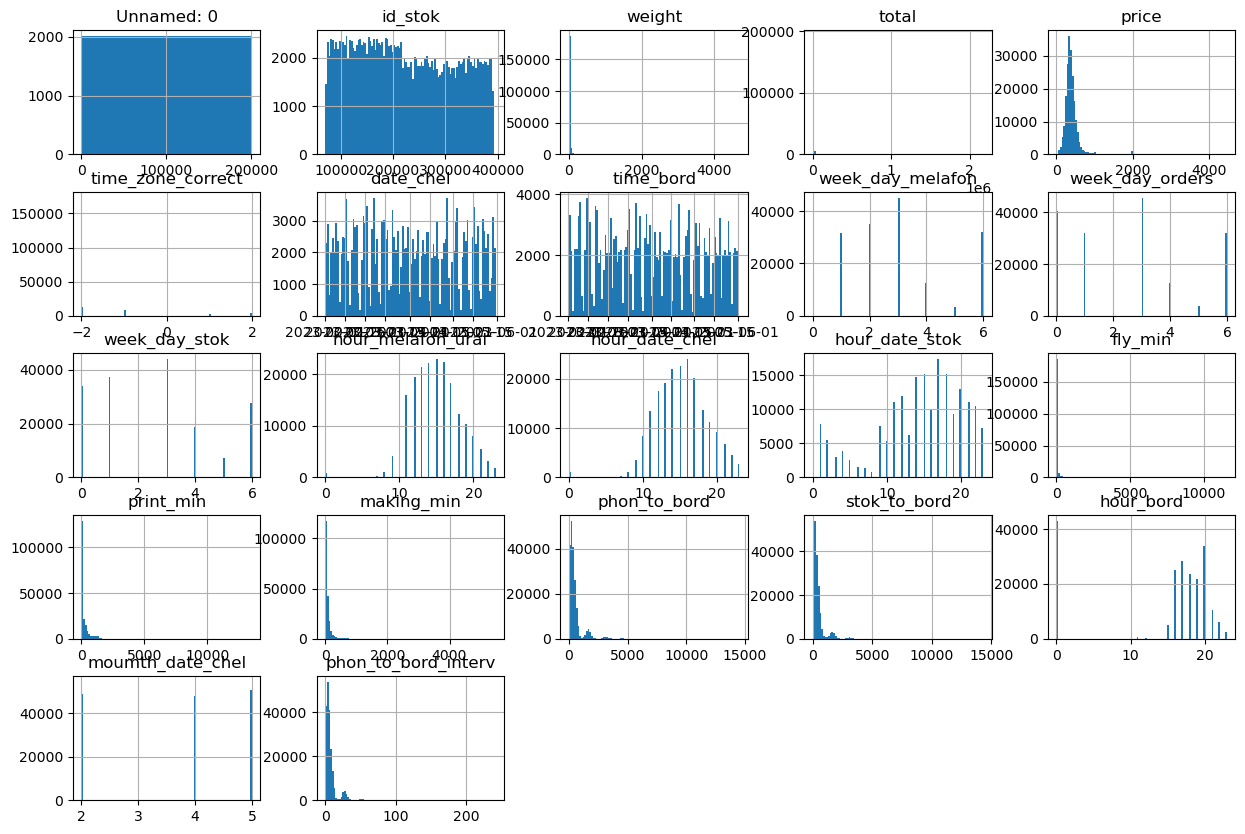

In [101]:
df_orders.hist(bins=100, figsize=(15, 10))

In [102]:
# Функция построения типовых гистограмм
def hist_pattern(df, title):
    df.hist(bins=100, figsize=(7,5))
    plt.title(title)
    return plt.show()


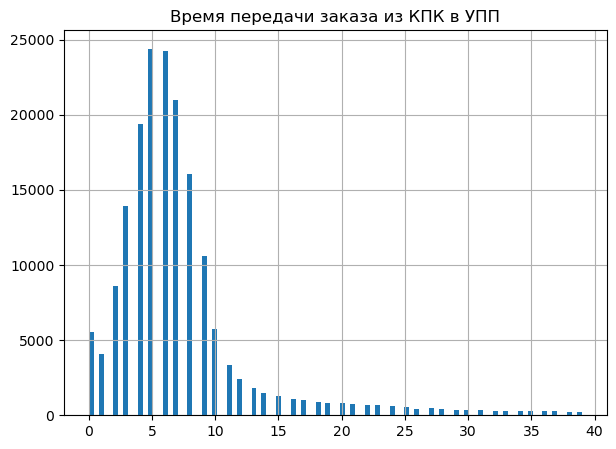

In [103]:
hist_pattern(df_orders[df_orders['fly_min']<40]['fly_min'], 'Время передачи заказа из КПК в УПП')

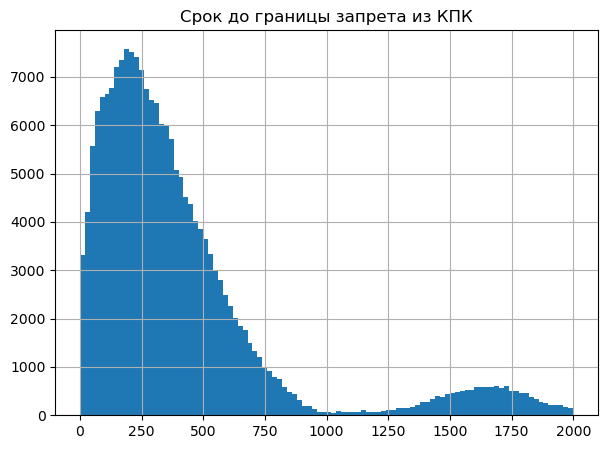

In [104]:
hist_pattern(df_orders[df_orders['phon_to_bord']<2000]['phon_to_bord'], 'Срок до границы запрета из КПК')

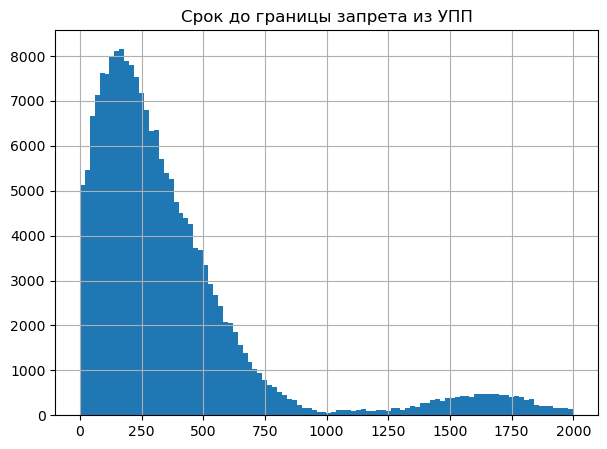

In [105]:
hist_pattern(df_orders[df_orders['stok_to_bord']<2000]['stok_to_bord'], 'Срок до границы запрета из УПП')

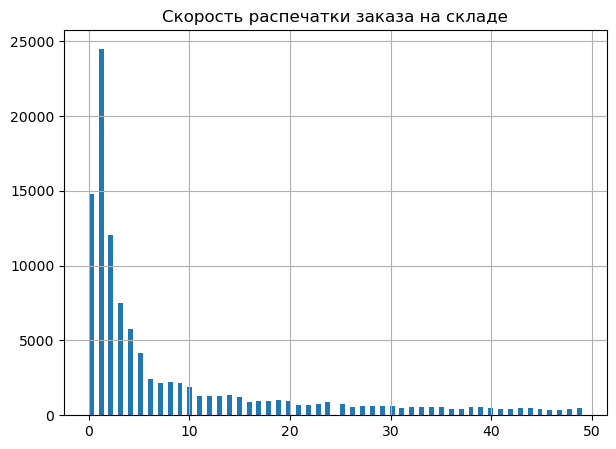

In [106]:
hist_pattern(df_orders[df_orders['print_min']<50]['print_min'], 'Скорость распечатки заказа на складе')

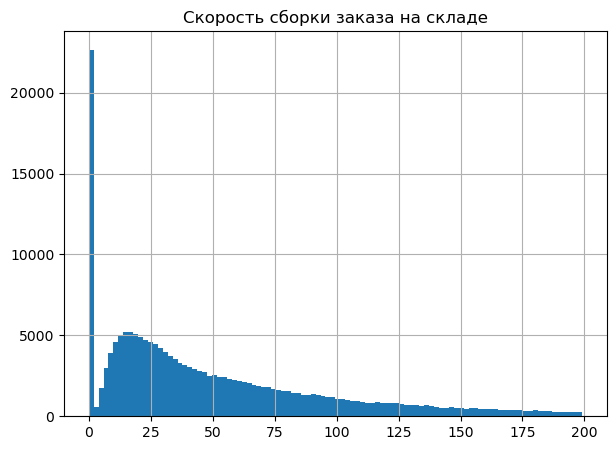

In [107]:
hist_pattern(df_orders[df_orders['making_min']<200]['making_min'], 'Скорость сборки заказа на складе')

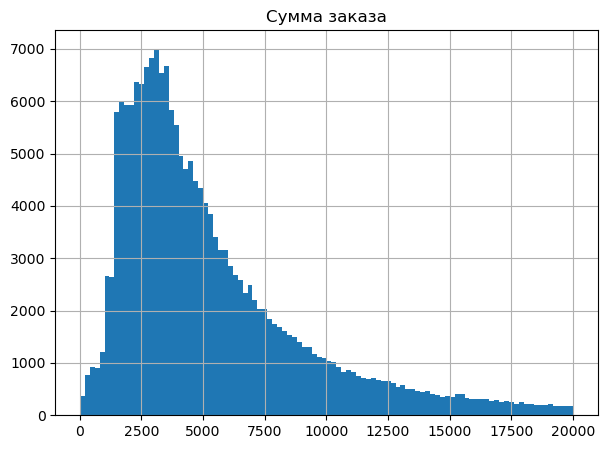

In [108]:
hist_pattern(df_orders[df_orders['total']<20000]['total'], 'Сумма заказа')

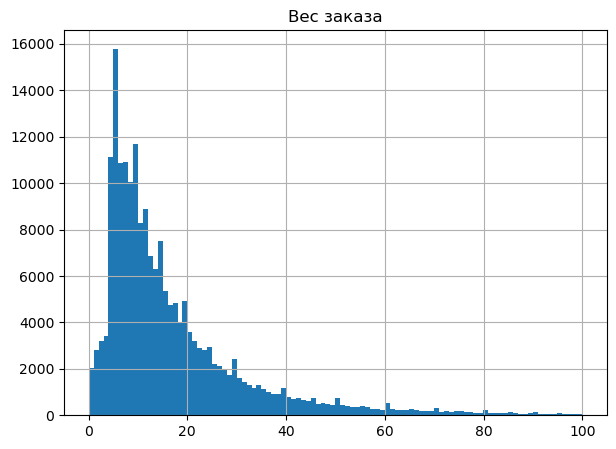

In [109]:
hist_pattern(df_orders[df_orders['weight']<100]['weight'], 'Вес заказа')

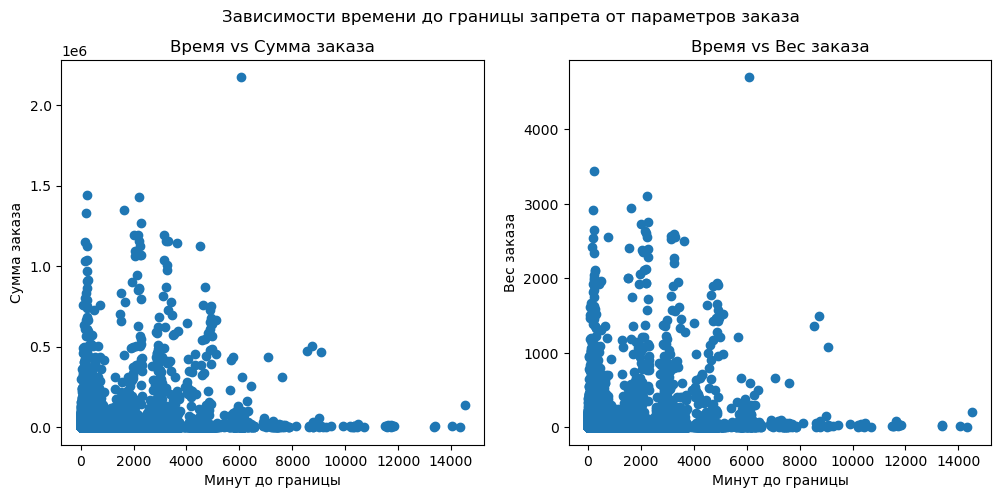

In [110]:
# Зависимости от параметров заказа

f, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(df_orders.loc[:, 'phon_to_bord'], 
               df_orders.loc[:, 'total'])
axs[0].set_title("Время vs Сумма заказа")
axs[0].set_xlabel("Минут до границы")
axs[0].set_ylabel("Сумма заказа")


axs[1].scatter(df_orders.loc[:,'phon_to_bord'], 
               df_orders.loc[:,'weight'])
axs[1].set_title("Время vs Вес заказа")
axs[1].set_xlabel("Минут до границы")
axs[1].set_ylabel("Вес заказа")

plt.suptitle("Зависимости времени до границы запрета от параметров заказа")
plt.show()

**Зависимости от параметров заказа**

In [111]:
# Группировка
df_hour_melafon_ural_total = df_orders.groupby('hour_melafon_ural').agg({
    'total': ['mean', 'sum'], 
    'weight': ['mean', 'sum'], 
    'id_stok': 'count'
})
df_hour_melafon_ural_total = df_hour_melafon_ural_total.reset_index()
df_hour_melafon_ural_total.columns = ['hour_melafon_ural', 'total_mean', 'total_sum', 'weight_mean', 'weight_sum', 'id_stok']

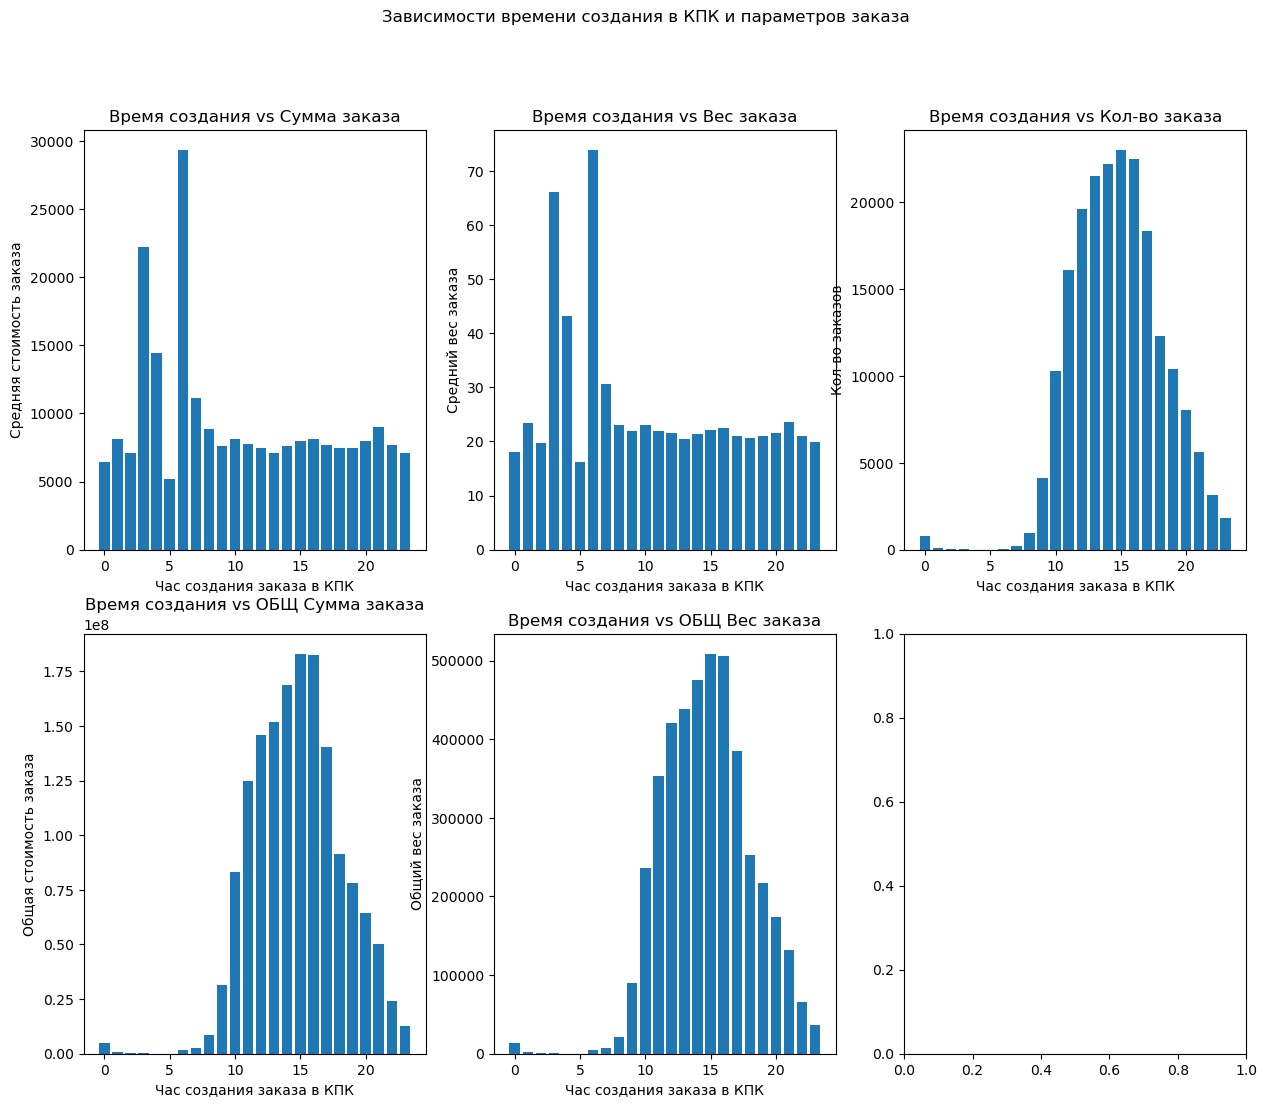

In [112]:
# График Зависимости времени создания в КПК и параметров заказа
f, axs = plt.subplots(2, 3, figsize=(15, 12))

axs[0,0].bar(x=df_hour_melafon_ural_total['hour_melafon_ural'], 
        height=df_hour_melafon_ural_total['total_mean'])
axs[0,0].set_title("Время создания vs Сумма заказа")
axs[0,0].set_xlabel("Час создания заказа в КПК")
axs[0,0].set_ylabel("Средняя стоимость заказа")

axs[0,1].bar(x=df_hour_melafon_ural_total['hour_melafon_ural'], 
        height=df_hour_melafon_ural_total['weight_mean'])
axs[0,1].set_title("Время создания vs Вес заказа")
axs[0,1].set_xlabel("Час создания заказа в КПК")
axs[0,1].set_ylabel("Средний вес заказа")

axs[0,2].bar(x=df_hour_melafon_ural_total['hour_melafon_ural'], 
        height=df_hour_melafon_ural_total['id_stok'])
axs[0,2].set_title("Время создания vs Кол-во заказа")
axs[0,2].set_xlabel("Час создания заказа в КПК")
axs[0,2].set_ylabel("Кол-во заказов")

axs[1,0].bar(x=df_hour_melafon_ural_total['hour_melafon_ural'], 
        height=df_hour_melafon_ural_total['total_sum'])
axs[1,0].set_title("Время создания vs ОБЩ Сумма заказа")
axs[1,0].set_xlabel("Час создания заказа в КПК")
axs[1,0].set_ylabel("Общая стоимость заказа")

axs[1,1].bar(x=df_hour_melafon_ural_total['hour_melafon_ural'], 
        height=df_hour_melafon_ural_total['weight_sum'])
axs[1,1].set_title("Время создания vs ОБЩ Вес заказа")
axs[1,1].set_xlabel("Час создания заказа в КПК")
axs[1,1].set_ylabel("Общий вес заказа")


plt.suptitle("Зависимости времени создания в КПК и параметров заказа")
plt.show()

In [113]:
# Группировка до 24 часов
df_phon_to_bord_total = df_orders.groupby(df_orders[df_orders['phon_to_bord_interv']<=24]['phon_to_bord_interv']).agg({
    'total': ['mean', 'sum'], 
    'weight': ['mean', 'sum'], 
    'id_stok': 'count'
})
df_phon_to_bord_total = df_phon_to_bord_total.reset_index()
df_phon_to_bord_total.columns = ['phon_to_bord_interv', 'total_mean', 'total_sum', 'weight_mean', 'weight_sum', 'id_stok']

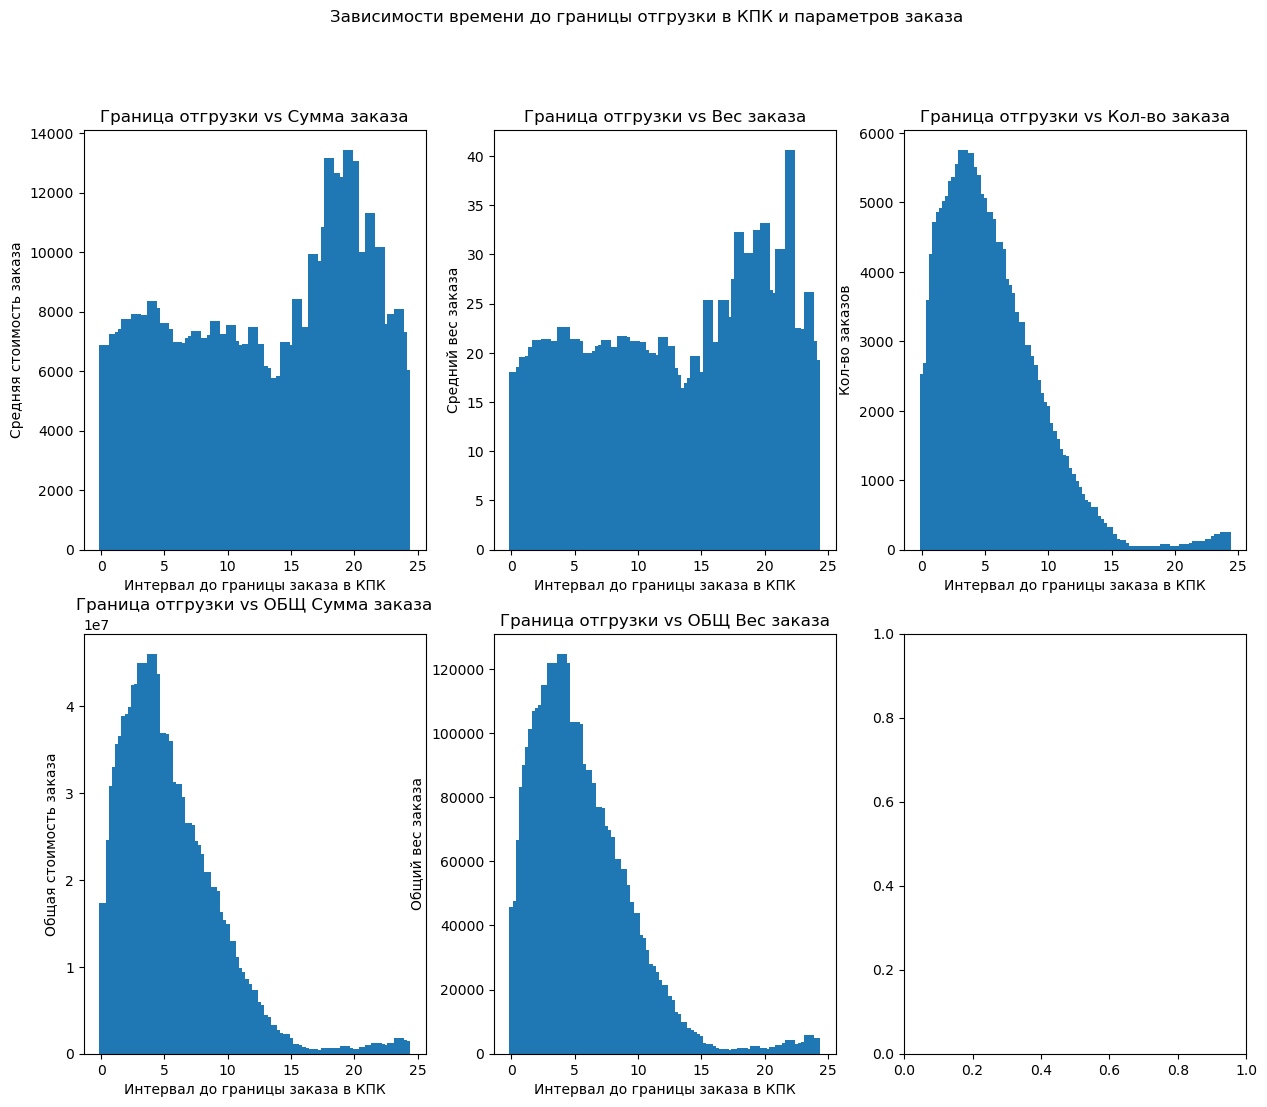

In [114]:
# График Зависимости времени до границы отгрузки в Мелафоне и параметров заказа
f, axs = plt.subplots(2, 3, figsize=(15, 12))

axs[0,0].bar(x=df_phon_to_bord_total['phon_to_bord_interv'], 
        height=df_phon_to_bord_total['total_mean'])
axs[0,0].set_title("Граница отгрузки vs Сумма заказа")
axs[0,0].set_xlabel("Интервал до границы заказа в КПК")
axs[0,0].set_ylabel("Средняя стоимость заказа")

axs[0,1].bar(x=df_phon_to_bord_total['phon_to_bord_interv'], 
        height=df_phon_to_bord_total['weight_mean'])
axs[0,1].set_title("Граница отгрузки vs Вес заказа")
axs[0,1].set_xlabel("Интервал до границы заказа в КПК")
axs[0,1].set_ylabel("Средний вес заказа")

axs[0,2].bar(x=df_phon_to_bord_total['phon_to_bord_interv'], 
        height=df_phon_to_bord_total['id_stok'])
axs[0,2].set_title("Граница отгрузки vs Кол-во заказа")
axs[0,2].set_xlabel("Интервал до границы заказа в КПК")
axs[0,2].set_ylabel("Кол-во заказов")

axs[1,0].bar(x=df_phon_to_bord_total['phon_to_bord_interv'], 
        height=df_phon_to_bord_total['total_sum'])
axs[1,0].set_title("Граница отгрузки vs ОБЩ Сумма заказа")
axs[1,0].set_xlabel("Интервал до границы заказа в КПК")
axs[1,0].set_ylabel("Общая стоимость заказа")

axs[1,1].bar(x=df_phon_to_bord_total['phon_to_bord_interv'], 
        height=df_phon_to_bord_total['weight_sum'])
axs[1,1].set_title("Граница отгрузки vs ОБЩ Вес заказа")
axs[1,1].set_xlabel("Интервал до границы заказа в КПК")
axs[1,1].set_ylabel("Общий вес заказа")


plt.suptitle("Зависимости времени до границы отгрузки в КПК и параметров заказа")
plt.show()


In [115]:
# Группировка до 24 часов
df_stop_bord_total = df_orders.groupby('stop_bord').agg({
    'total': ['mean', 'sum'], 
    'weight': ['mean', 'sum'], 
    'id_stok': 'count'
})
df_stop_bord_total = df_stop_bord_total.reset_index()
df_stop_bord_total.columns = ['stop_bord', 'total_mean', 'total_sum', 'weight_mean', 'weight_sum', 'id_stok']

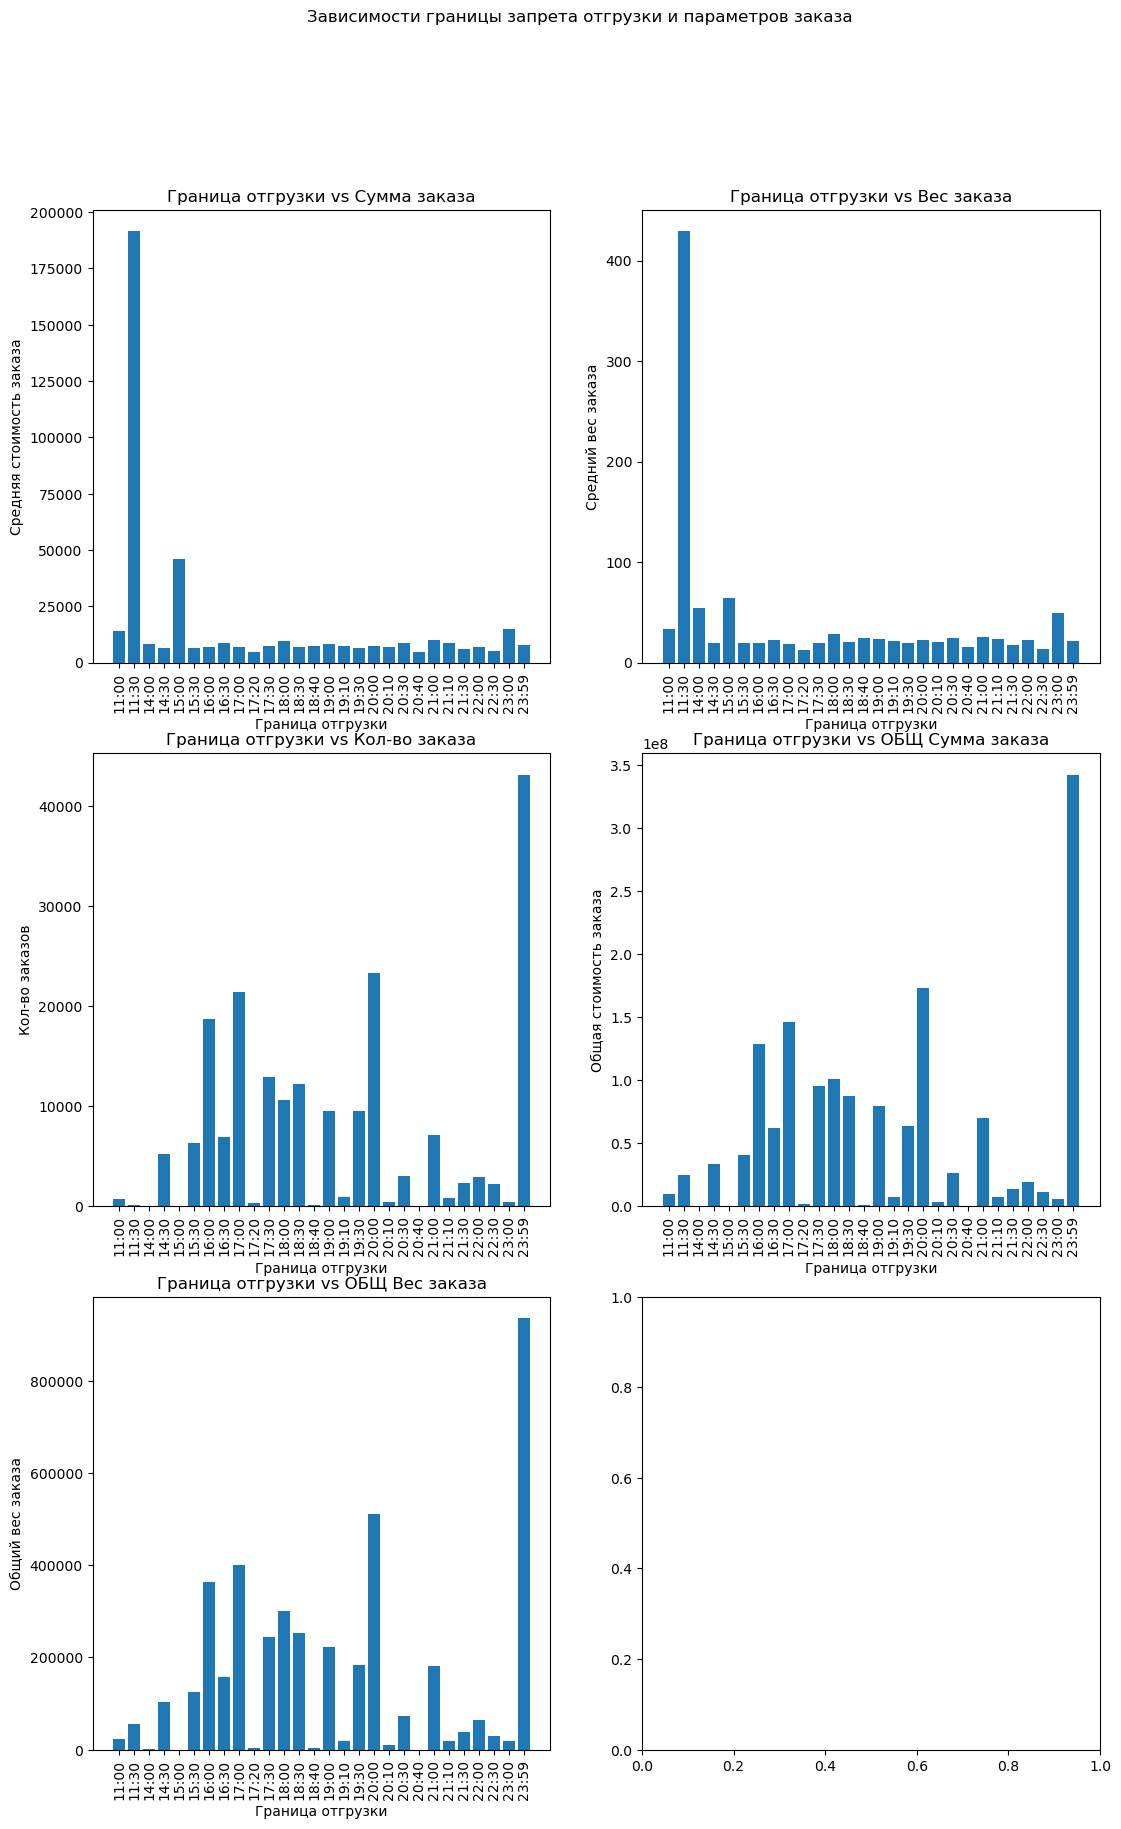

In [116]:
# График
f, axs = plt.subplots(3, 2, figsize=(13, 20))

axs[0,0].bar(x=df_stop_bord_total['stop_bord'], 
        height=df_stop_bord_total['total_mean'])
axs[0,0].set_title("Граница отгрузки vs Сумма заказа")
axs[0,0].set_xlabel("Граница отгрузки")
axs[0,0].set_ylabel("Средняя стоимость заказа")
axs[0,0].tick_params(axis='x', labelrotation = 90)

axs[0,1].bar(x=df_stop_bord_total['stop_bord'], 
        height=df_stop_bord_total['weight_mean'])
axs[0,1].set_title("Граница отгрузки vs Вес заказа")
axs[0,1].set_xlabel("Граница отгрузки")
axs[0,1].set_ylabel("Средний вес заказа")
axs[0,1].tick_params(axis='x', labelrotation = 90)

axs[1,0].bar(x=df_stop_bord_total['stop_bord'], 
        height=df_stop_bord_total['id_stok'])
axs[1,0].set_title("Граница отгрузки vs Кол-во заказа")
axs[1,0].set_xlabel("Граница отгрузки")
axs[1,0].set_ylabel("Кол-во заказов")
axs[1,0].tick_params(axis='x', labelrotation = 90)

axs[1,1].bar(x=df_stop_bord_total['stop_bord'], 
        height=df_stop_bord_total['total_sum'])
axs[1,1].set_title("Граница отгрузки vs ОБЩ Сумма заказа")
axs[1,1].set_xlabel("Граница отгрузки")
axs[1,1].set_ylabel("Общая стоимость заказа")
axs[1,1].tick_params(axis='x', labelrotation = 90)

axs[2,0].bar(x=df_stop_bord_total['stop_bord'], 
        height=df_stop_bord_total['weight_sum'])
axs[2,0].set_title("Граница отгрузки vs ОБЩ Вес заказа")
axs[2,0].set_xlabel("Граница отгрузки")
axs[2,0].set_ylabel("Общий вес заказа")
axs[2,0].tick_params(axis='x', labelrotation = 90)


plt.suptitle("Зависимости границы запрета отгрузки и параметров заказа")
plt.show()


In [117]:
df_day_weight_sum = df_orders.pivot_table(index='stop_bord', columns='week_day_orders', 
                                         values='weight', aggfunc='sum')
df_day_weight_sum = df_day_weight_sum.reset_index()
df_day_weight_sum.columns = ['stop_bord', 'пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс']

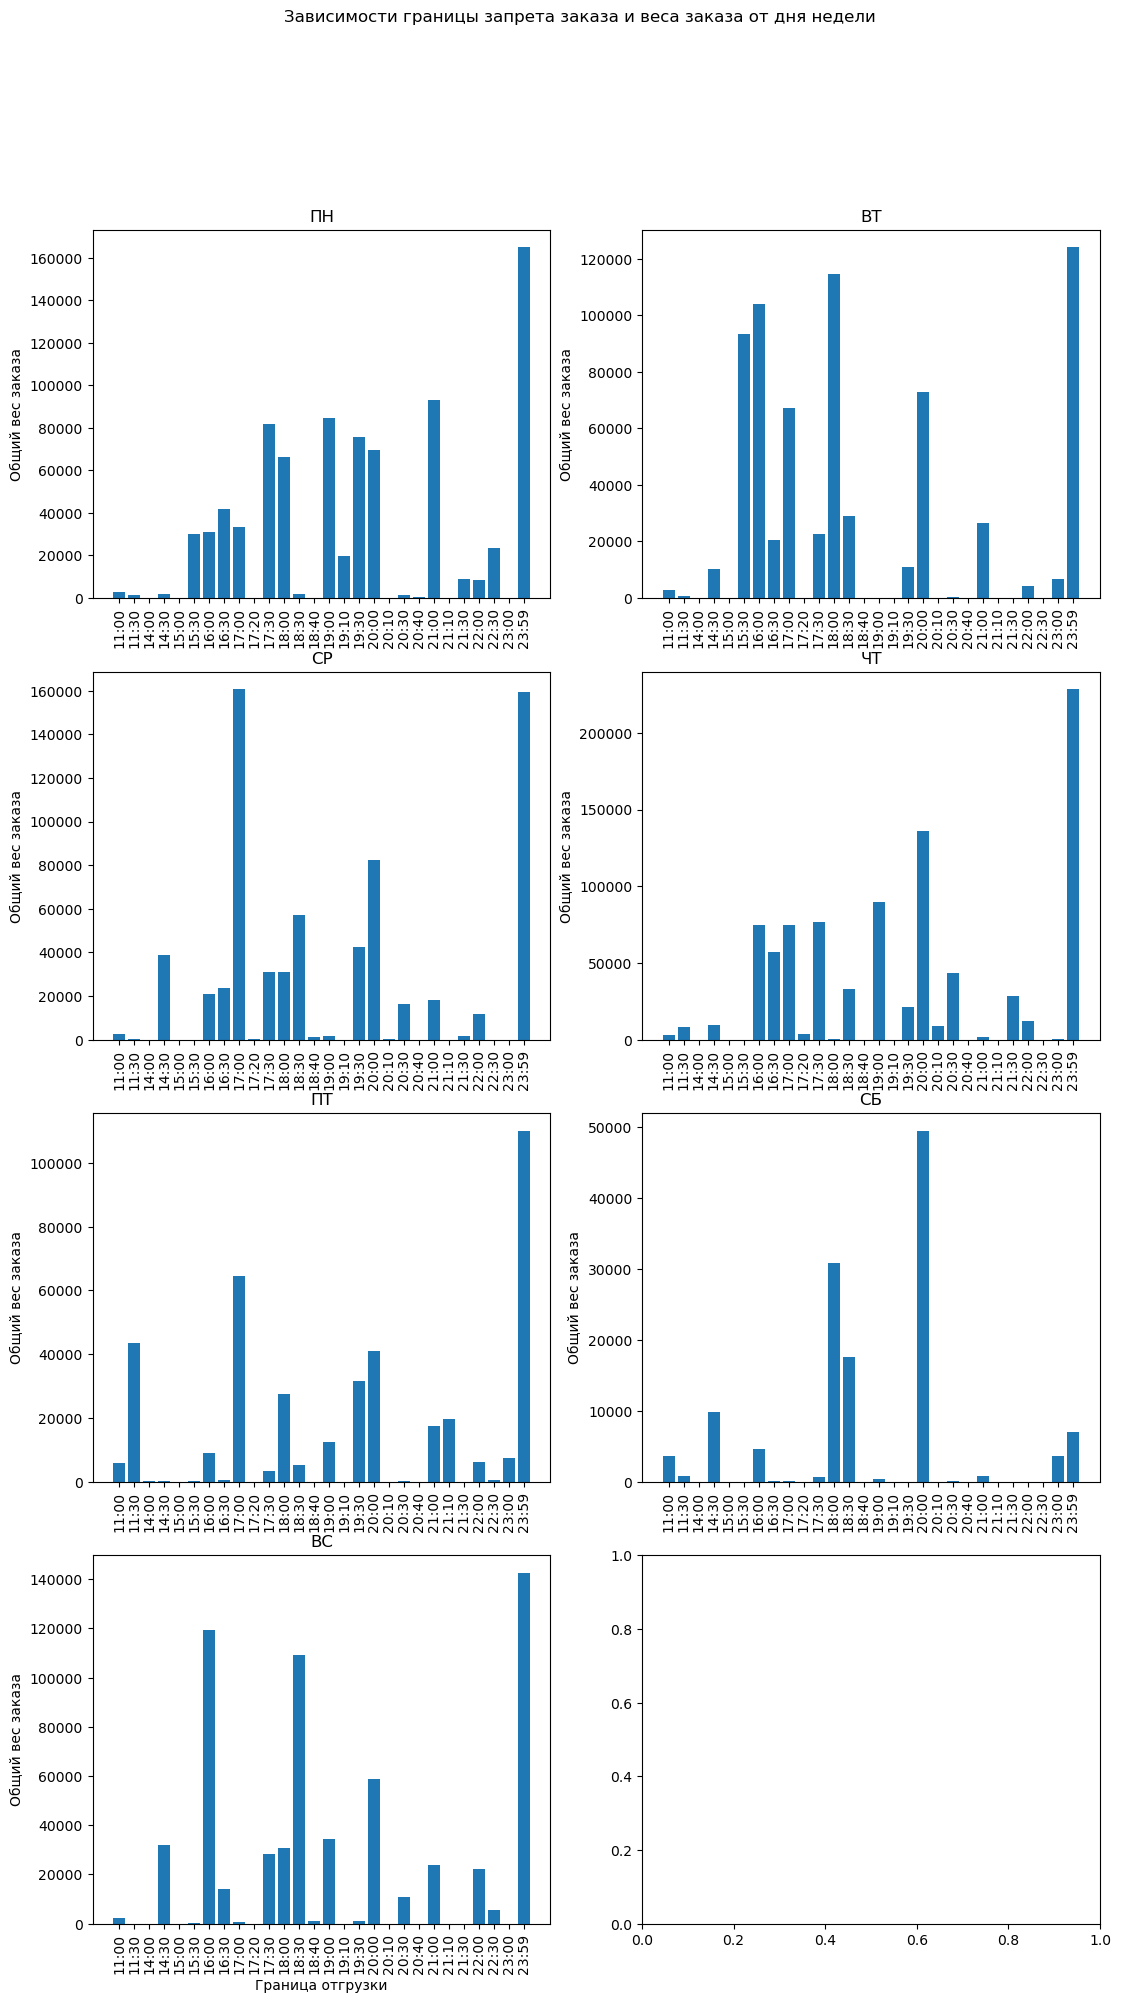

In [118]:
# График
f, axs = plt.subplots(4, 2, figsize=(13, 22))

axs[0,0].bar(x=df_day_weight_sum['stop_bord'], 
        height=df_day_weight_sum['пн'])
axs[0,0].set_title("ПН")
axs[0,0].set_ylabel("Общий вес заказа")
axs[0,0].tick_params(axis='x', labelrotation = 90)

axs[0,1].bar(x=df_day_weight_sum['stop_bord'], 
        height=df_day_weight_sum['вт'])
axs[0,1].set_title("ВТ")
axs[0,1].set_ylabel("Общий вес заказа")
axs[0,1].tick_params(axis='x', labelrotation = 90)

axs[1,0].bar(x=df_day_weight_sum['stop_bord'], 
        height=df_day_weight_sum['ср'])
axs[1,0].set_title("СР")
axs[1,0].set_ylabel("Общий вес заказа")
axs[1,0].tick_params(axis='x', labelrotation = 90)

axs[1,1].bar(x=df_day_weight_sum['stop_bord'], 
        height=df_day_weight_sum['чт'])
axs[1,1].set_title("ЧТ")
axs[1,1].set_ylabel("Общий вес заказа")
axs[1,1].tick_params(axis='x', labelrotation = 90)

axs[2,0].bar(x=df_day_weight_sum['stop_bord'], 
        height=df_day_weight_sum['пт'])
axs[2,0].set_title("ПТ")
axs[2,0].set_ylabel("Общий вес заказа")
axs[2,0].tick_params(axis='x', labelrotation = 90)

axs[2,1].bar(x=df_day_weight_sum['stop_bord'], 
        height=df_day_weight_sum['сб'])
axs[2,1].set_title("СБ")
axs[2,1].set_ylabel("Общий вес заказа")
axs[2,1].tick_params(axis='x', labelrotation = 90)

axs[3,0].bar(x=df_day_weight_sum['stop_bord'], 
        height=df_day_weight_sum['вс'])
axs[3,0].set_title("ВС")
axs[3,0].set_xlabel("Граница отгрузки")
axs[3,0].set_ylabel("Общий вес заказа")
axs[3,0].tick_params(axis='x', labelrotation = 90)

plt.suptitle("Зависимости границы запрета заказа и веса заказа от дня недели")
plt.show()

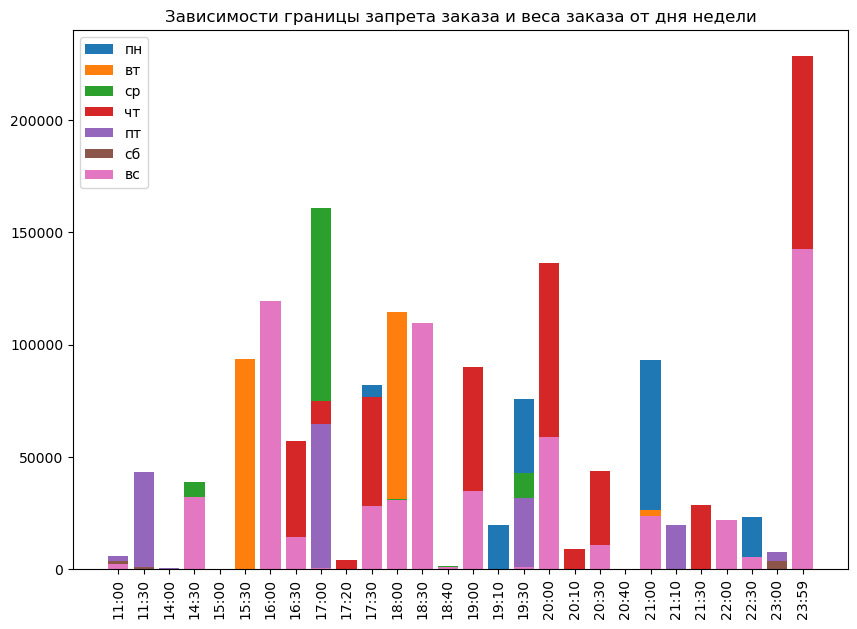

In [119]:
# График Зависимости границы запрета заказа и веса заказа от дня недели

f, axs = plt.subplots(figsize=(10, 7))

for i in range(len(wd)):
    i = axs.bar(x=df_day_weight_sum['stop_bord'],
                height=df_day_weight_sum[wd[i]], label=wd[i])
    
axs.legend()
axs.tick_params(axis='x', labelrotation = 90)
plt.title("Зависимости границы запрета заказа и веса заказа от дня недели")
plt.show()

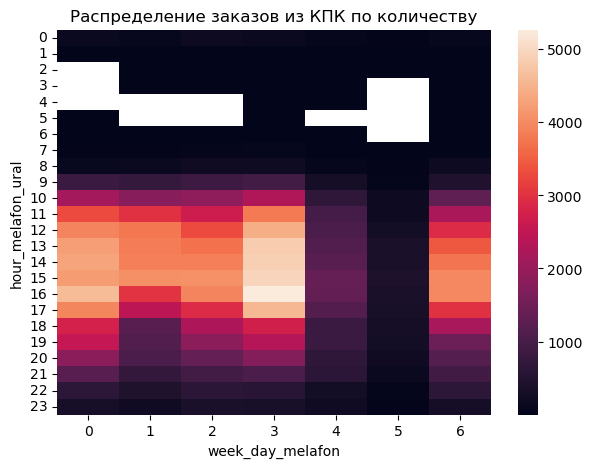

In [120]:
# Распределение заказов из КПК по количеству

df_melofon_count = df_orders.pivot_table(index='hour_melafon_ural', columns='week_day_melafon', 
                                         values='id_stok', aggfunc='count')
plt.figure(figsize=(7, 5))
heatmap = sns.heatmap(df_melofon_count)
heatmap.set_title('Распределение заказов из КПК по количеству')
plt.show()

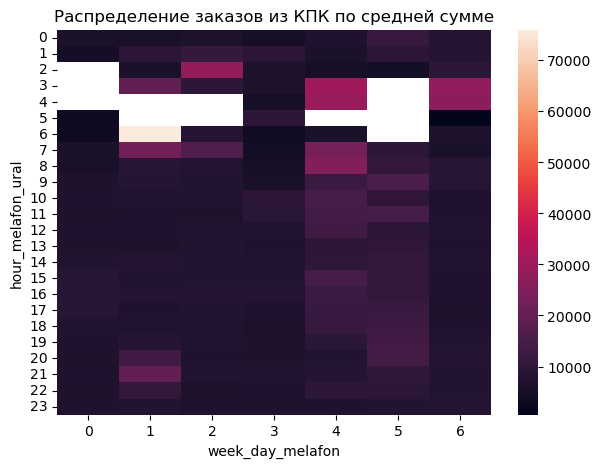

In [121]:
# Распределение заказов из КПК по средней сумме

df_melofon_mean_total = df_orders.pivot_table(index='hour_melafon_ural', columns='week_day_melafon', 
                                         values='total', aggfunc='mean')
plt.figure(figsize=(7, 5))
heatmap = sns.heatmap(df_melofon_mean_total)
heatmap.set_title('Распределение заказов из КПК по средней сумме')
plt.show()

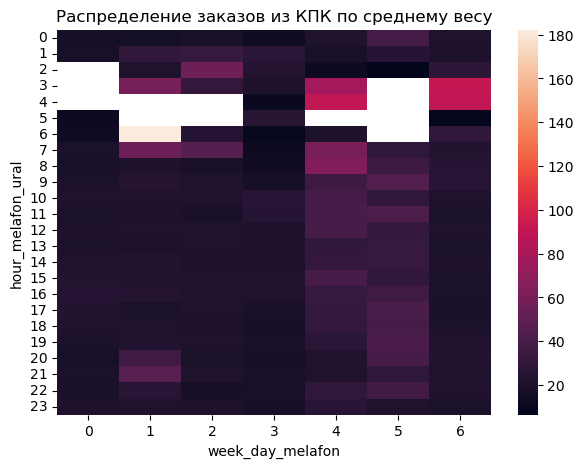

In [122]:
# Распределение заказов из КПК по среднему весу

df_melofon_mean_weight = df_orders.pivot_table(index='hour_melafon_ural', columns='week_day_melafon', 
                                         values='weight', aggfunc='mean')
plt.figure(figsize=(7, 5))
heatmap = sns.heatmap(df_melofon_mean_weight)
heatmap.set_title('Распределение заказов из КПК по среднему весу')
plt.show()

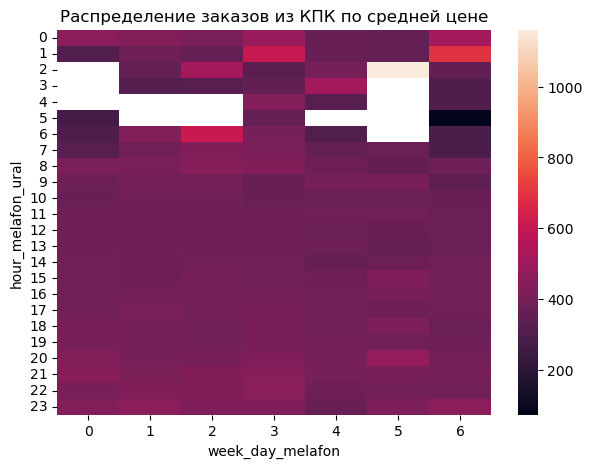

In [123]:
# Распределение заказов из КПК по средней цене

df_melofon_mean_price = df_orders.pivot_table(index='hour_melafon_ural', columns='week_day_melafon', 
                                         values='price', aggfunc='mean')
plt.figure(figsize=(7, 5))
heatmap = sns.heatmap(df_melofon_mean_price)
heatmap.set_title('Распределение заказов из КПК по средней цене')
plt.show()

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>],
       [<Axes: title={'center': '3'}>, <Axes: title={'center': '4'}>,
        <Axes: title={'center': '5'}>],
       [<Axes: title={'center': '6'}>, <Axes: >, <Axes: >]], dtype=object)

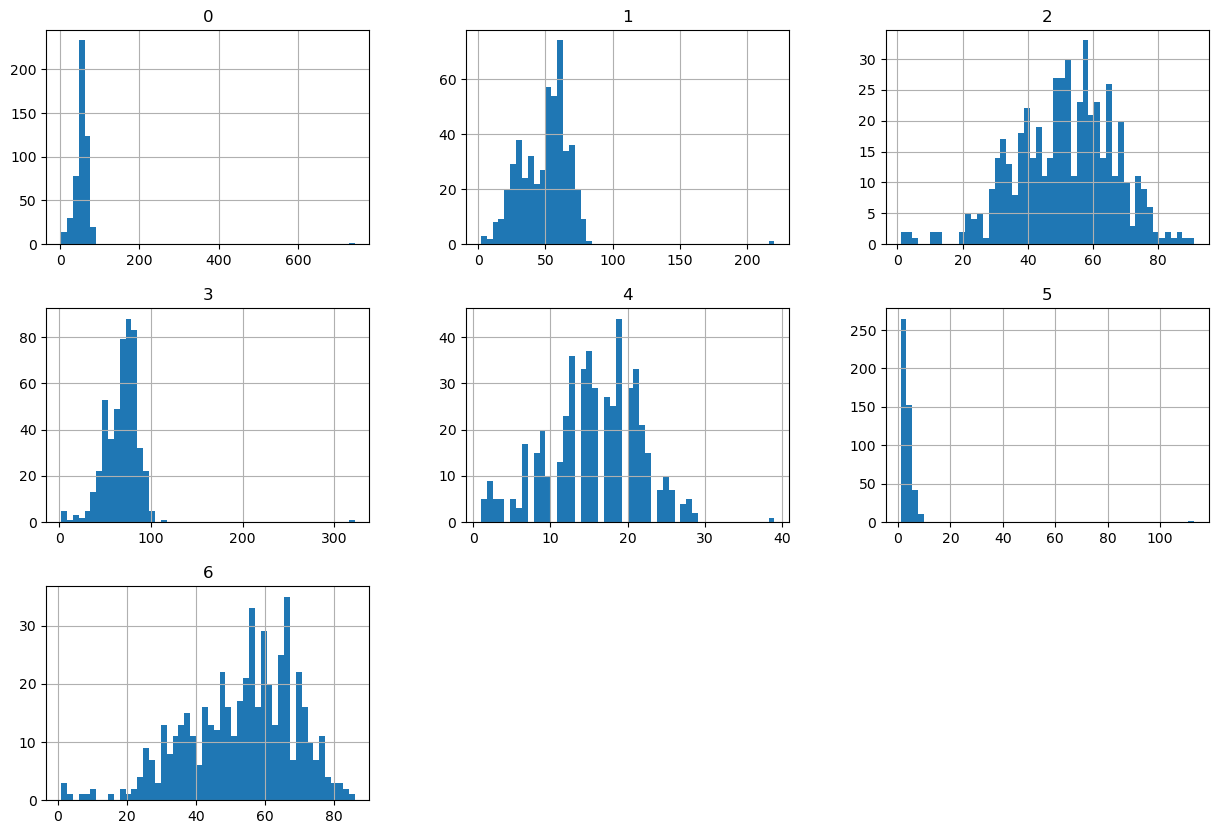

In [124]:
# Распределение заказов из КПК по времени до границы запрета

df_melofon_to_bord_count = df_orders.loc[df_orders['phon_to_bord']<500].pivot_table(index='phon_to_bord',
                                                                                     columns='week_day_melafon', 
                                                                                     values='id_stok', 
                                                                                     aggfunc='count')
df_melofon_to_bord_count.hist(bins=50, figsize=(15, 10))

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>],
       [<Axes: title={'center': '3'}>, <Axes: title={'center': '4'}>,
        <Axes: title={'center': '5'}>],
       [<Axes: title={'center': '6'}>, <Axes: >, <Axes: >]], dtype=object)

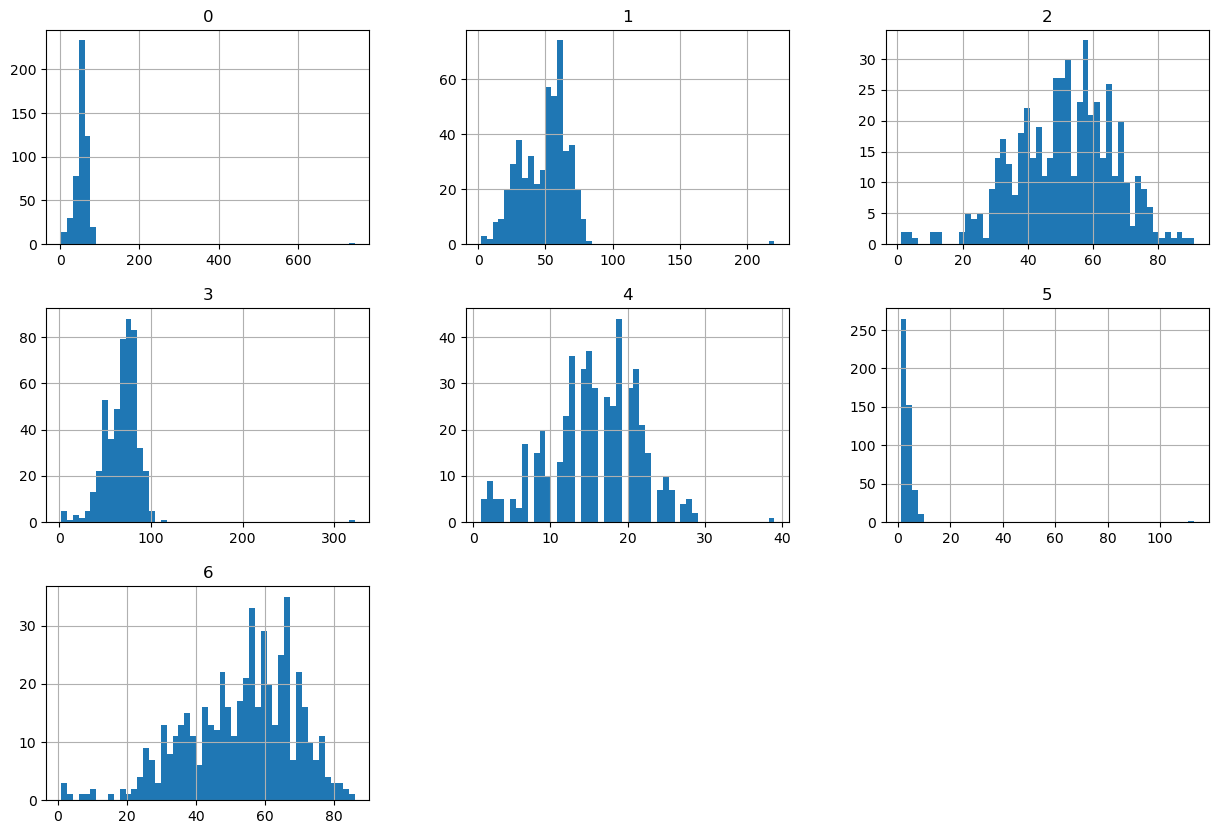

In [125]:
# Распределение заказов из УПП по времени до границы запрета

df_stok_to_bord_count = df_orders.loc[df_orders['stok_to_bord']<500].pivot_table(index='stok_to_bord',
                                                                                     columns='week_day_orders', 
                                                                                     values='id_stok', 
                                                                                     aggfunc='count')
df_melofon_to_bord_count.hist(bins=50, figsize=(15, 10))

In [126]:
# Группировка по часам Поступление и Сборки заказа
df_hour_chel = df_orders.groupby(df_orders[df_orders['moumth_date_chel']==5]['hour_date_chel']).agg({
    'id_stok': 'count' 
})
df_hour_chel = df_hour_chel.reset_index()
df_hour_chel.columns = ['hour_date_chel', 'stok_count']


# Группировка по часам Сборка заказа
df_hour_stok = df_orders.groupby(df_orders[df_orders['moumth_date_chel']==5]['hour_date_stok']).agg({
    'id_stok': 'count'
})
df_hour_stok = df_hour_stok.reset_index()
df_hour_stok.columns = ['hour_date_stok', 'stok_count']

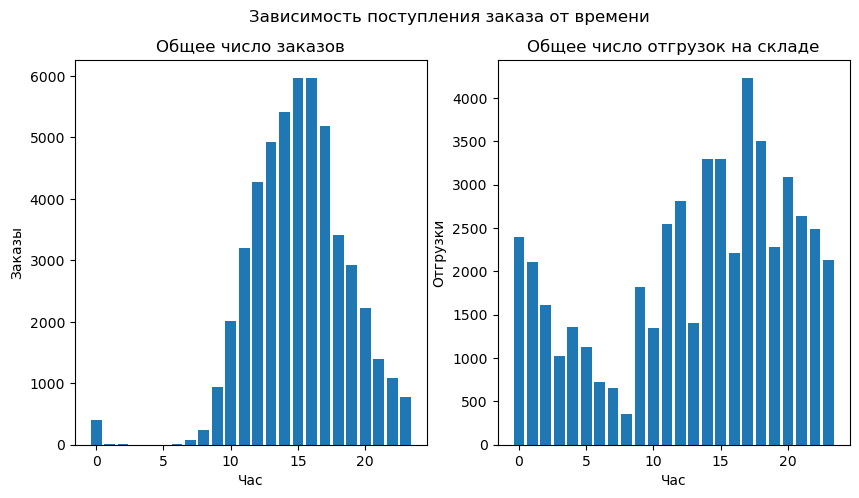

In [127]:
# График Зависимость поступления заказа от времени
f, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].bar(x=df_hour_chel['hour_date_chel'], 
        height=df_hour_chel['stok_count'])
axs[0].set_title("Общее число заказов")
axs[0].set_xlabel("Час")
axs[0].set_ylabel("Заказы")

axs[1].bar(x=df_hour_stok['hour_date_stok'], 
        height=df_hour_stok['stok_count'])
axs[1].set_title("Общее число отгрузок на складе")
axs[1].set_xlabel("Час")
axs[1].set_ylabel("Отгрузки")

plt.suptitle("Зависимость поступления заказа от времени")
plt.show()

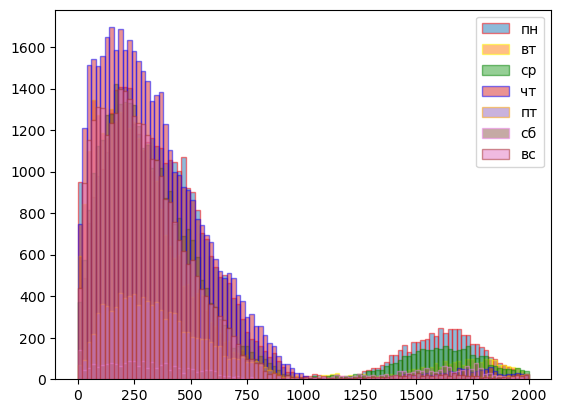

In [128]:
coll = ['red', 'yellow', 'green', 'blue', 'orange', 'violet', 'brown']
for i in range(7):
    plt.hist(df_orders[(df_orders['week_day_melafon']==i)&(df_orders['phon_to_bord']<2000)]['phon_to_bord'], 
         label=wd[i], bins=100, alpha=.5, edgecolor=coll[i])
 

plt.legend()
plt.show()

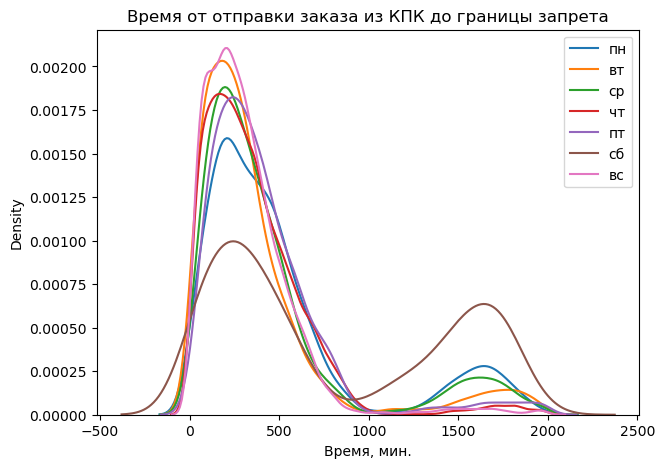

In [129]:
# Время от отправки заказа из КПК до границы запрета

plt.figure(figsize=(7, 5))
for i in range(7):
    sns.kdeplot(df_orders[(df_orders['week_day_melafon']==i)&(df_orders['phon_to_bord']<2000)]['phon_to_bord'], label=wd[i])

plt.xlabel("Время, мин.")
plt.title('Время от отправки заказа из КПК до границы запрета')
plt.legend()
plt.show()

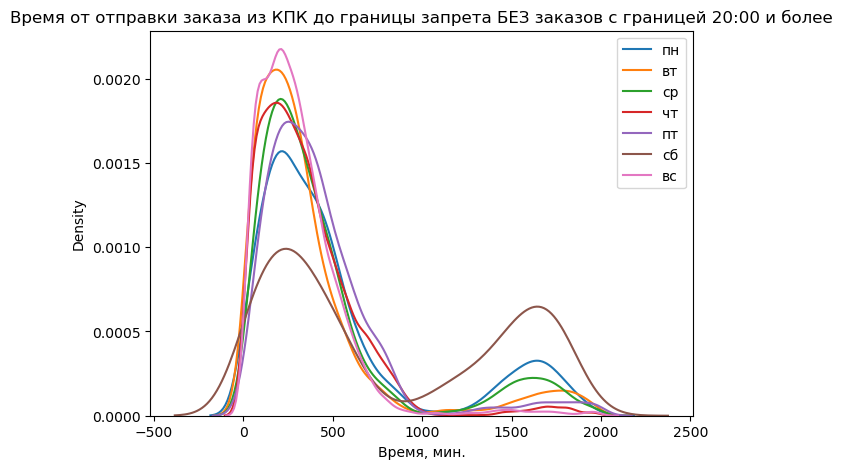

In [130]:
# Время от отправки заказа из КПК до границы запрета БЕЗ заказов с границей 20:00 и более

plt.figure(figsize=(7, 5))

for i in range(7):
    sns.kdeplot(df_orders[(df_orders['week_day_melafon']==i)
                      &(df_orders['phon_to_bord']<2000)
                      &(df_orders['hour_bord']<=20)]['phon_to_bord'], label=wd[i])

plt.xlabel("Время, мин.")
plt.title('Время от отправки заказа из КПК до границы запрета БЕЗ заказов с границей 20:00 и более')
plt.legend()
plt.show()

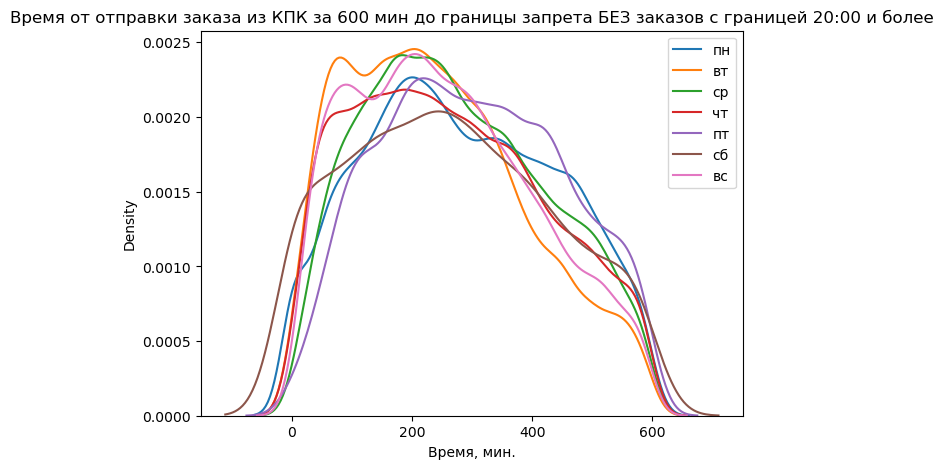

In [131]:
# Время от отправки заказа из КПК за 600 мин до границы запрета БЕЗ заказов с границей 20:00 и более

plt.figure(figsize=(7, 5))

for i in range(7):
    sns.kdeplot(df_orders[(df_orders['week_day_melafon']==i)
                      &(df_orders['phon_to_bord']<600)
                      &(df_orders['hour_bord']<=20)]['phon_to_bord'], label=wd[i])

plt.xlabel("Время, мин.")
plt.title('Время от отправки заказа из КПК за 600 мин до границы запрета БЕЗ заказов с границей 20:00 и более')
plt.legend()
plt.show()

**Распределение заказов по отделам**

In [132]:
# Отделы
reg_1 = df_orders['region'].unique()[:10]
reg_2 = df_orders['region'].unique()[10:20]
reg_3 = df_orders['region'].unique()[20:]

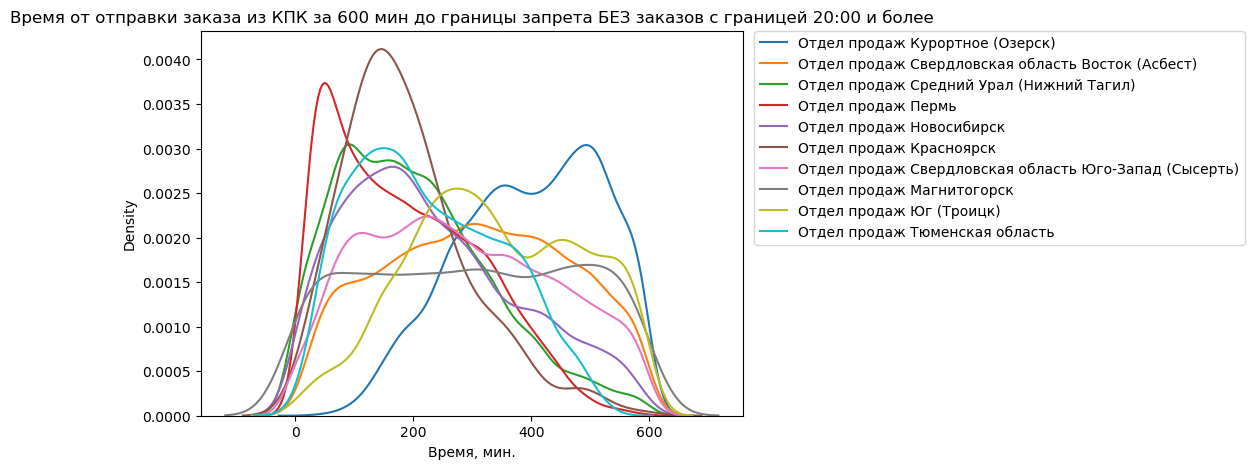

In [133]:
plt.figure(figsize=(7, 5))

for i in range(len(reg_1)):
    sns.kdeplot(df_orders[(df_orders['region']==reg_1[i])
                      &(df_orders['phon_to_bord']<600)
                      &(df_orders['hour_bord']<=20)]['phon_to_bord'], label=reg_1[i])

plt.xlabel("Время, мин.")
plt.title('Время от отправки заказа из КПК за 600 мин до границы запрета БЕЗ заказов с границей 20:00 и более')
plt.legend(bbox_to_anchor=(1.02 , 1), loc='upper left', borderaxespad= 0)
plt.show()

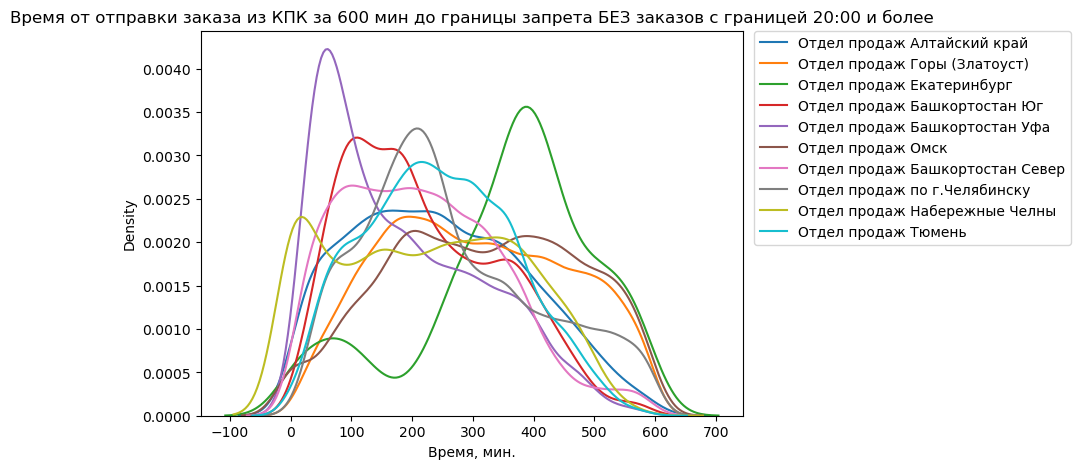

In [134]:
plt.figure(figsize=(7, 5))

for i in range(len(reg_2)):
    sns.kdeplot(df_orders[(df_orders['region']==reg_2[i])
                      &(df_orders['phon_to_bord']<600)
                      &(df_orders['hour_bord']<=20)]['phon_to_bord'], label=reg_2[i])

plt.xlabel("Время, мин.")
plt.title('Время от отправки заказа из КПК за 600 мин до границы запрета БЕЗ заказов с границей 20:00 и более')
plt.legend(bbox_to_anchor=(1.02 , 1), loc='upper left', borderaxespad= 0)
plt.show()

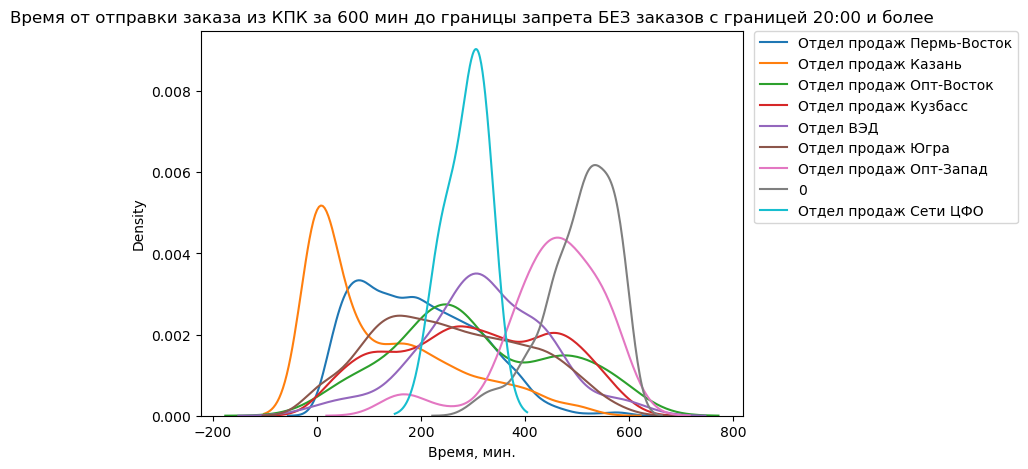

In [135]:
plt.figure(figsize=(7, 5))

for i in range(len(reg_3)):
    sns.kdeplot(df_orders[(df_orders['region']==reg_3[i])
                      &(df_orders['phon_to_bord']<600)
                      &(df_orders['hour_bord']<=20)]['phon_to_bord'], label=reg_3[i])

plt.xlabel("Время, мин.")
plt.title('Время от отправки заказа из КПК за 600 мин до границы запрета БЕЗ заказов с границей 20:00 и более')
plt.legend(bbox_to_anchor=(1.02 , 1), loc='upper left', borderaxespad= 0)
plt.show()

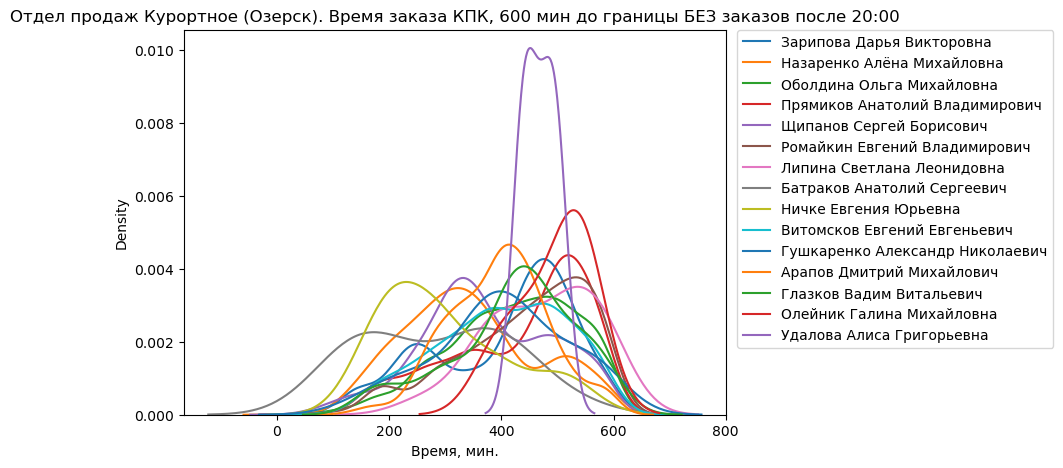

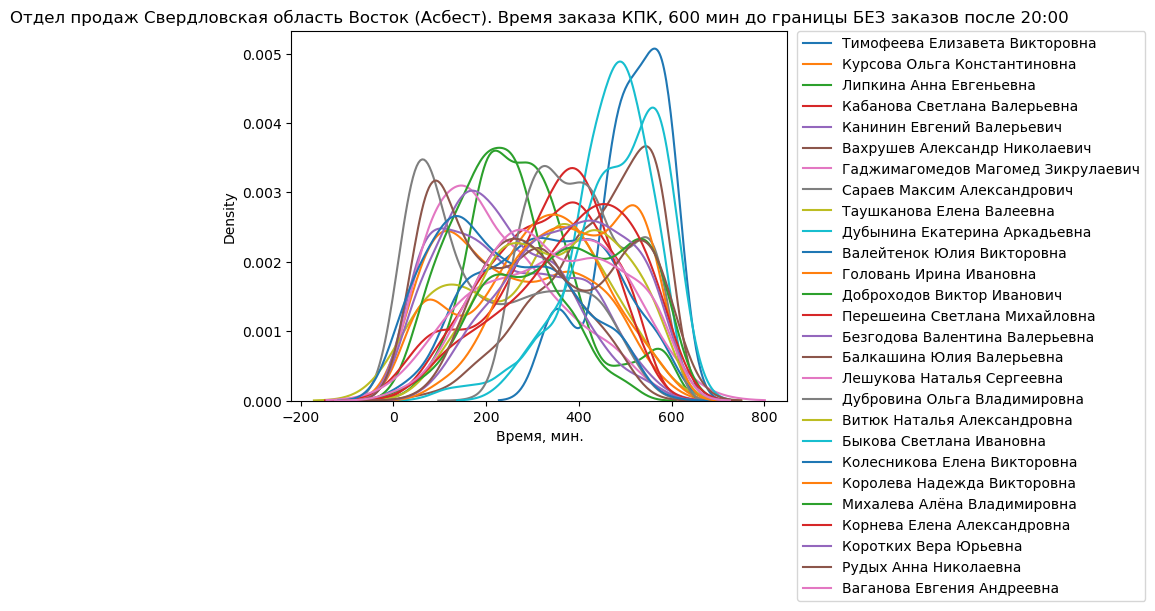

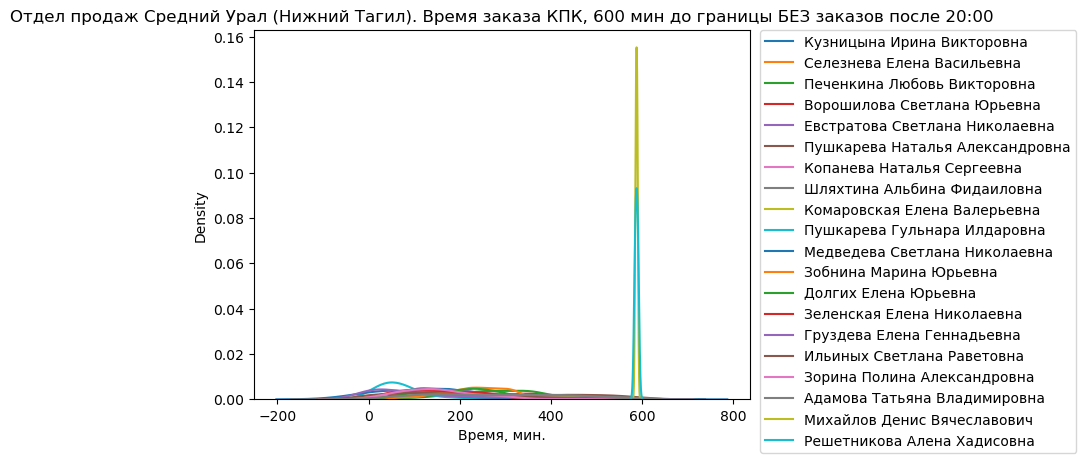

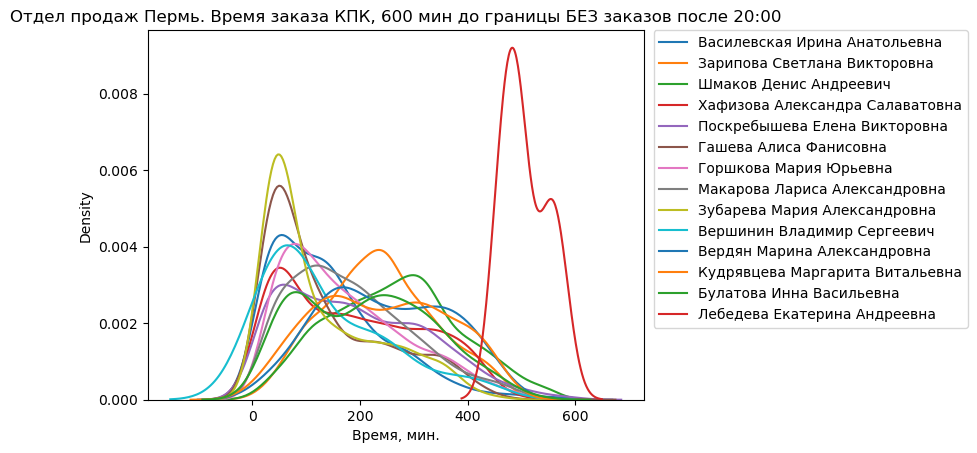

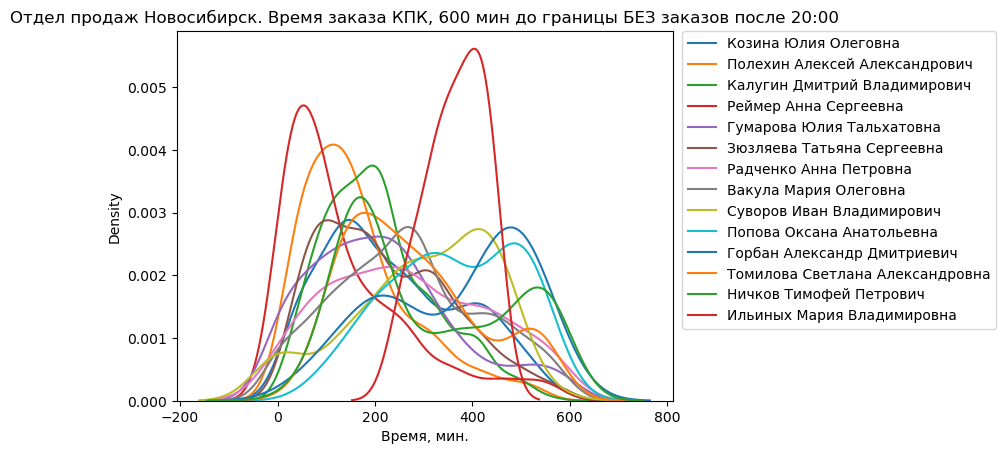

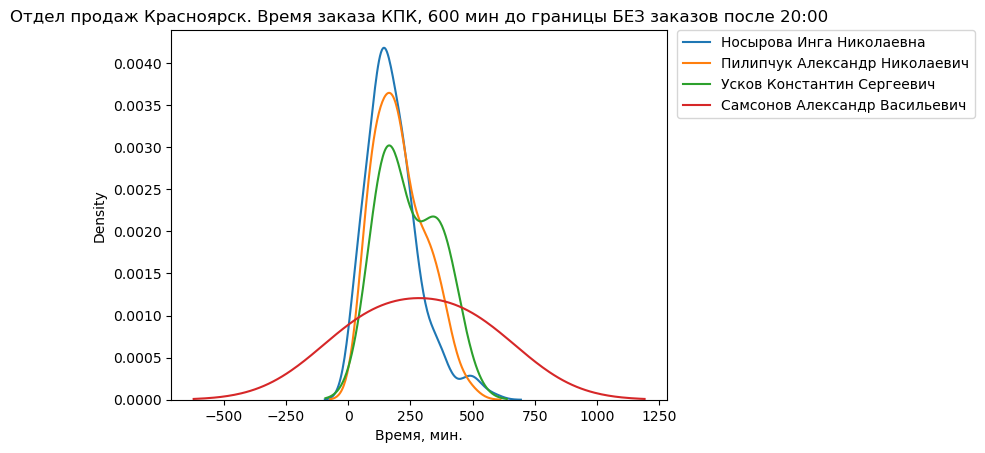

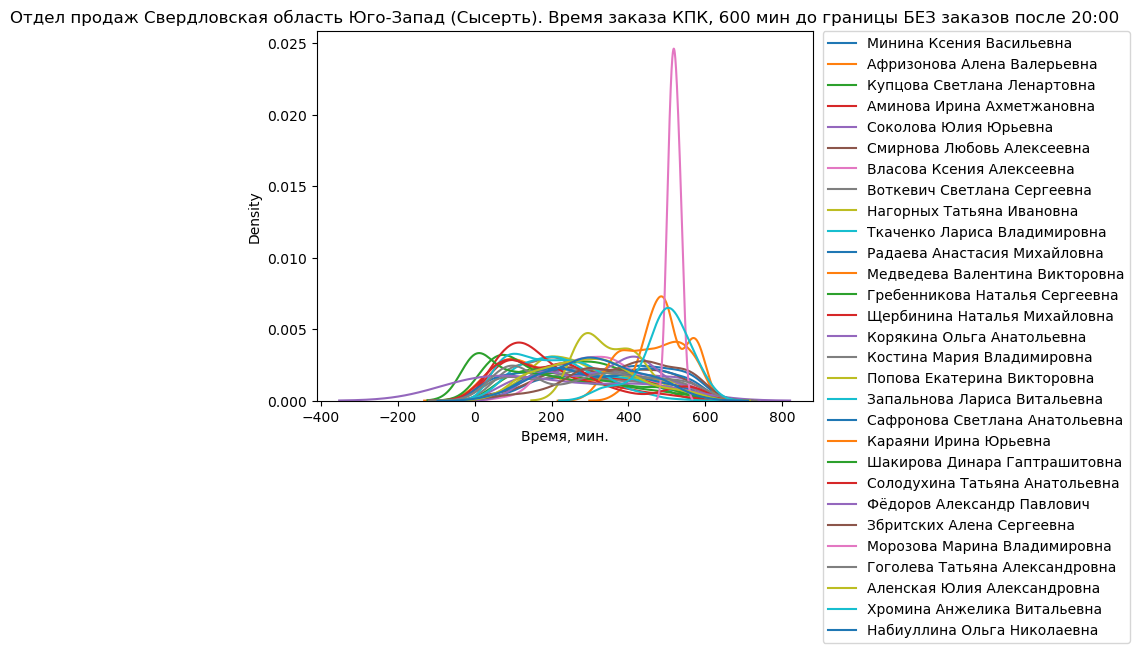

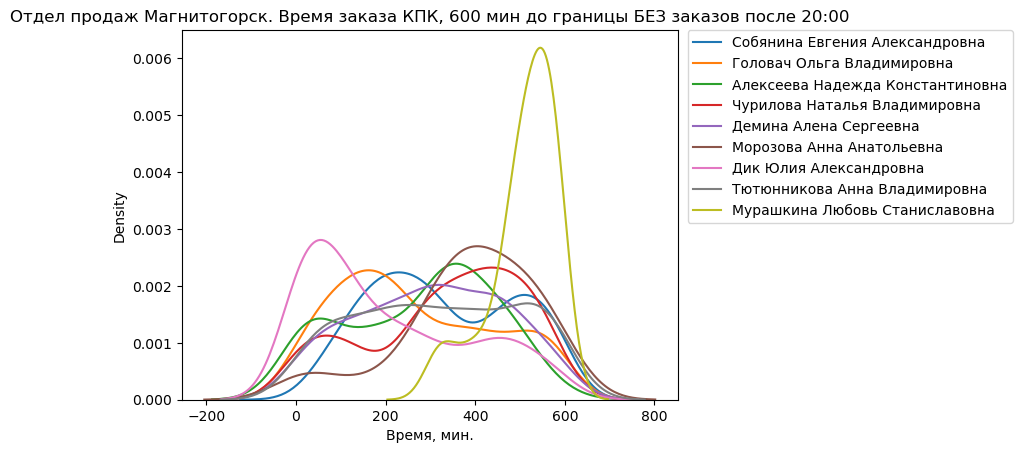

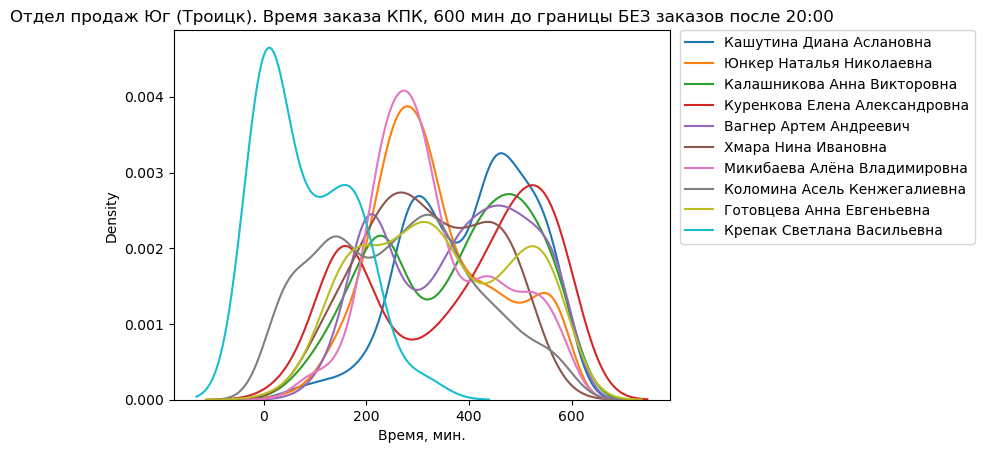

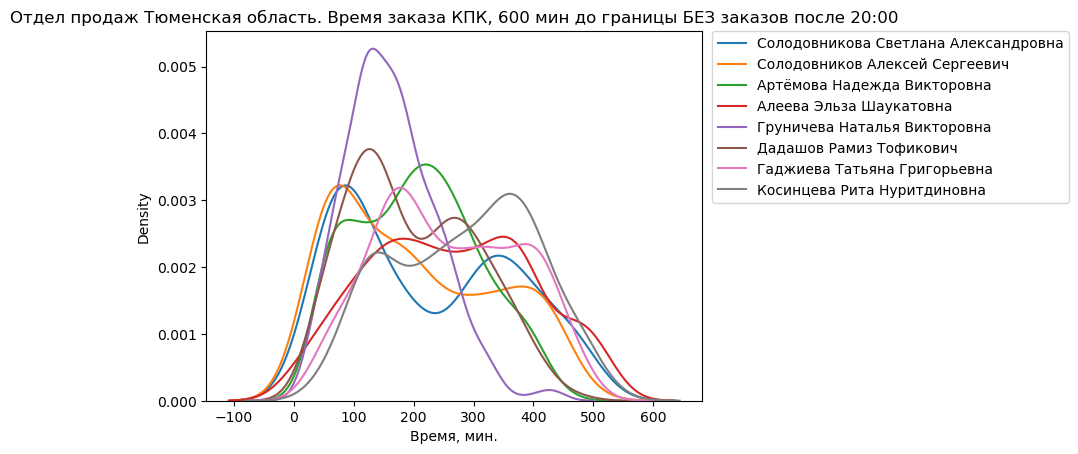

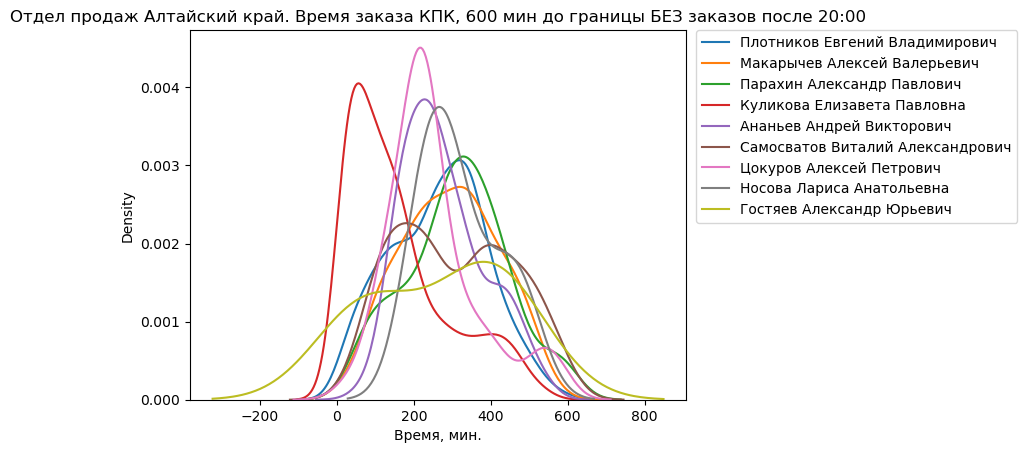

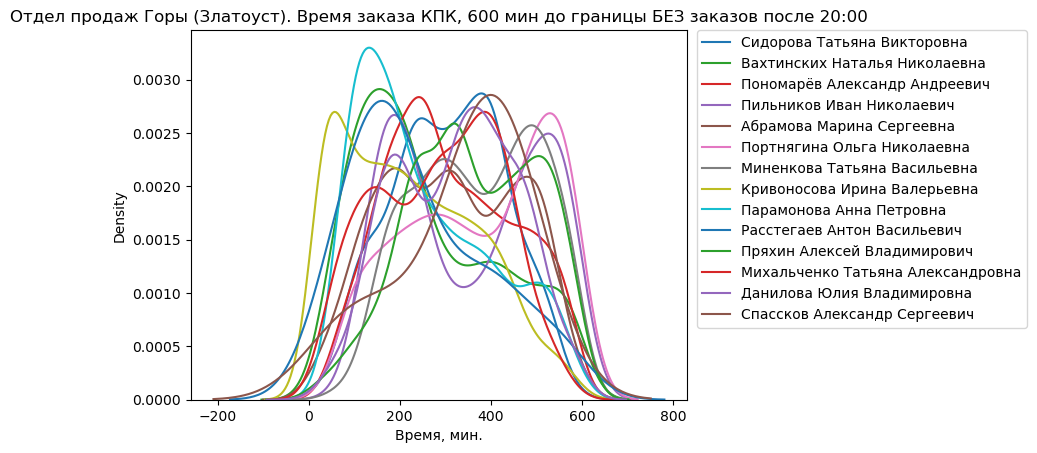

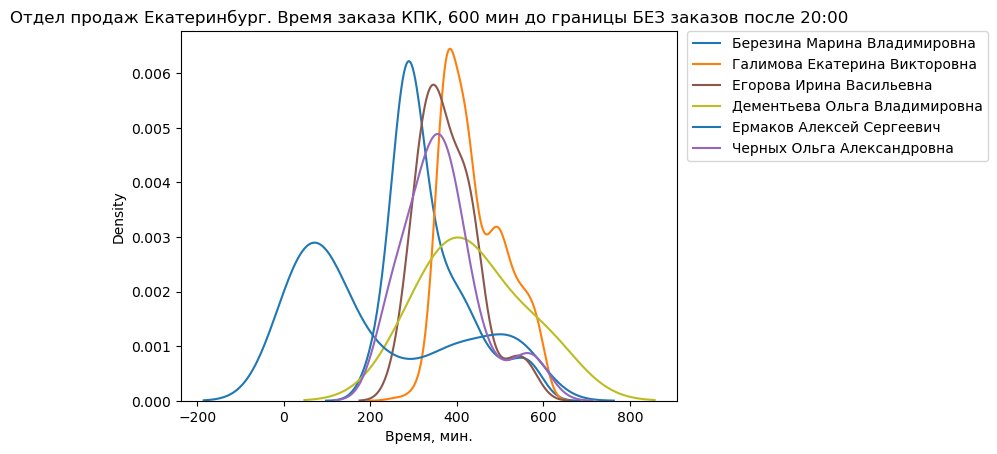

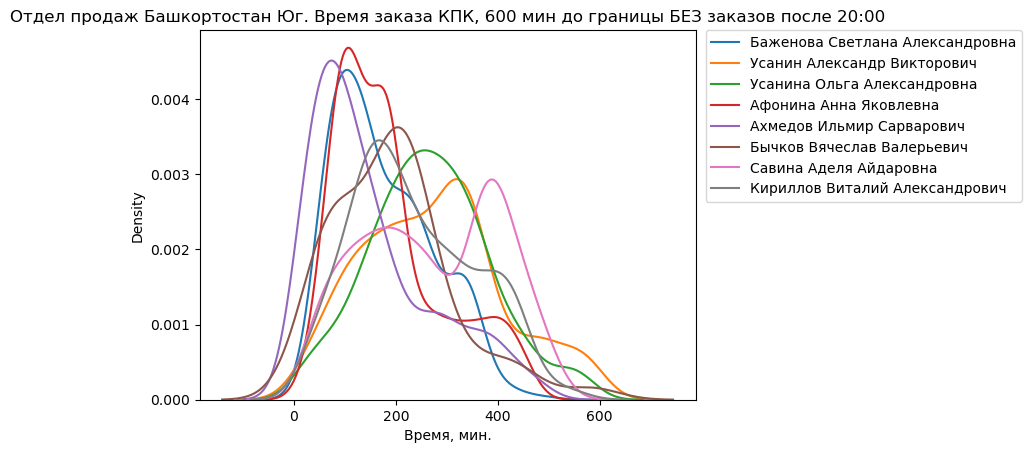

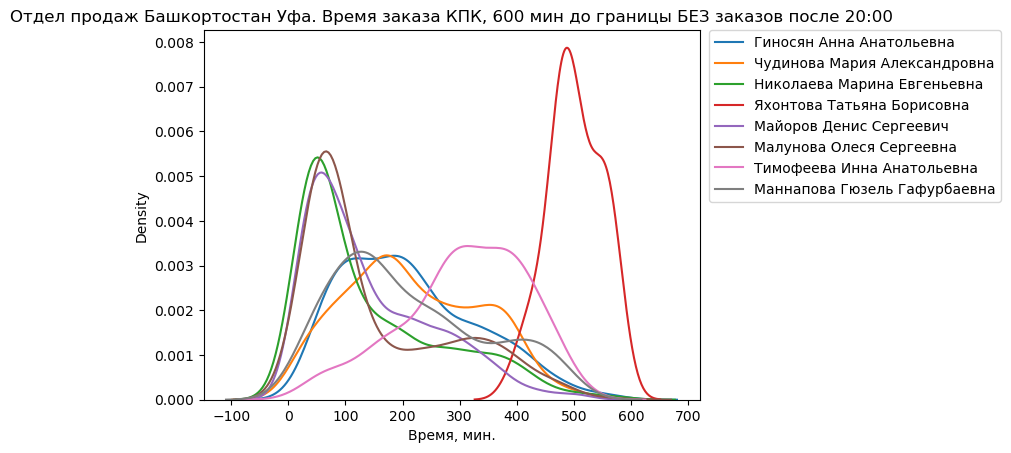

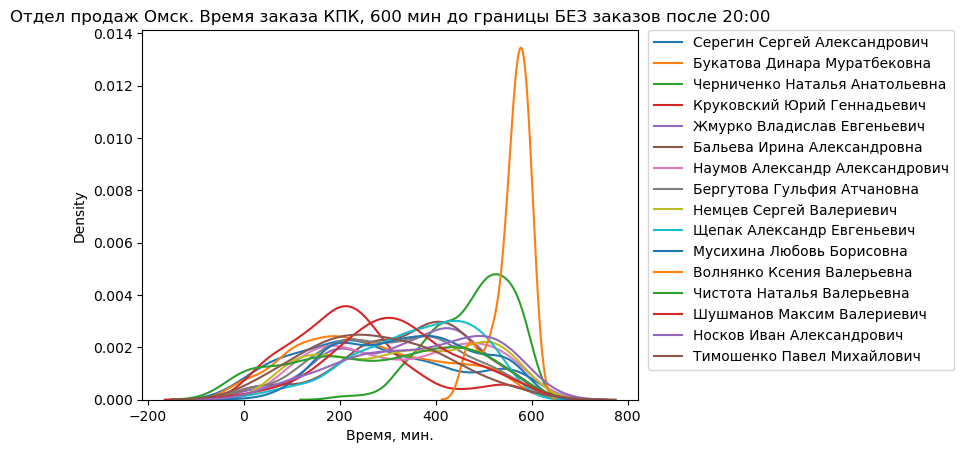

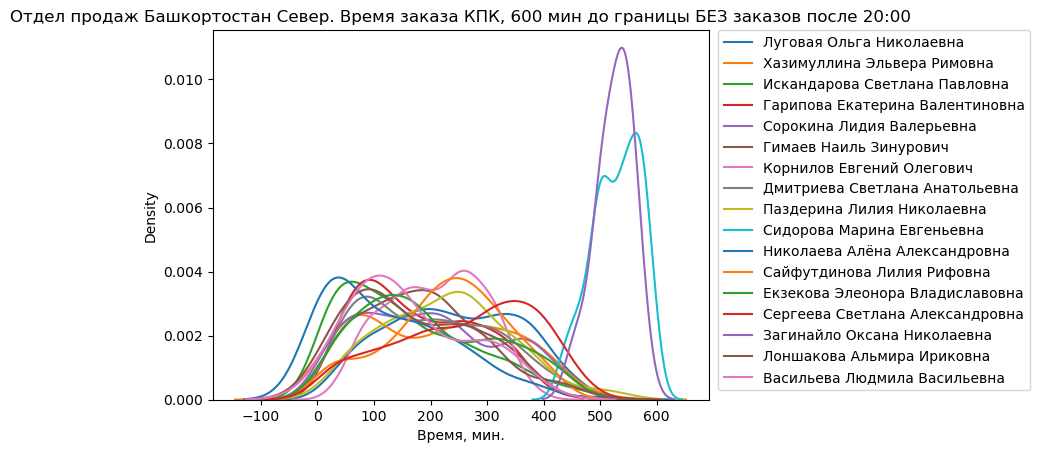

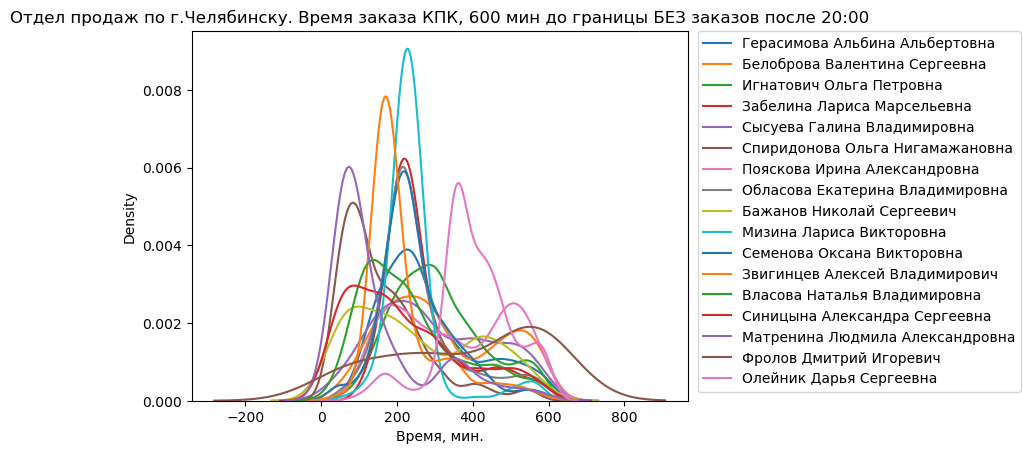

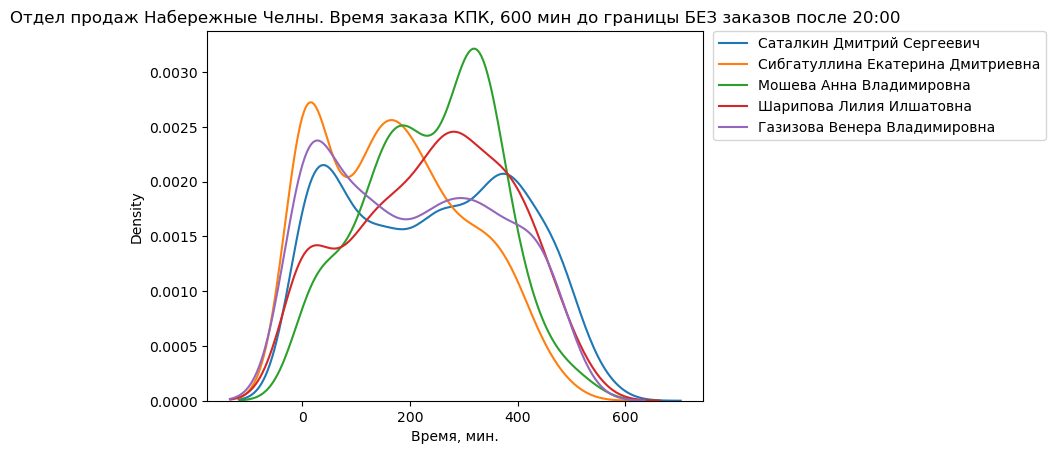

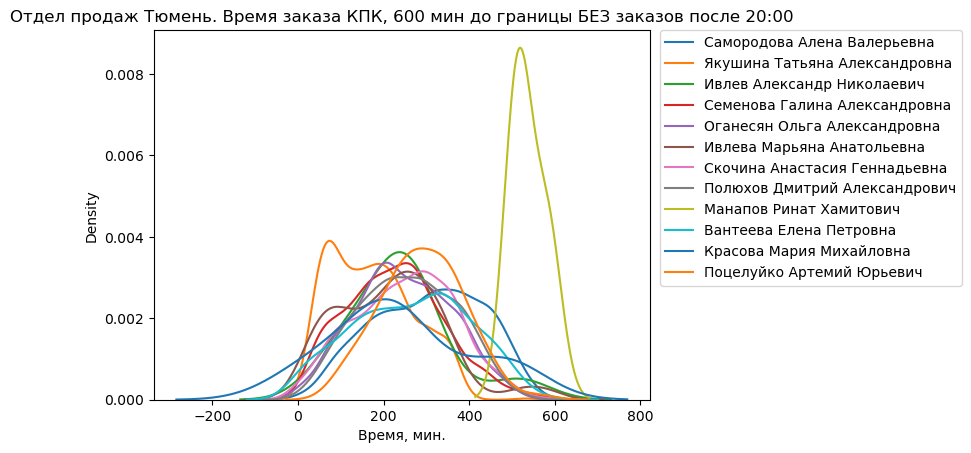

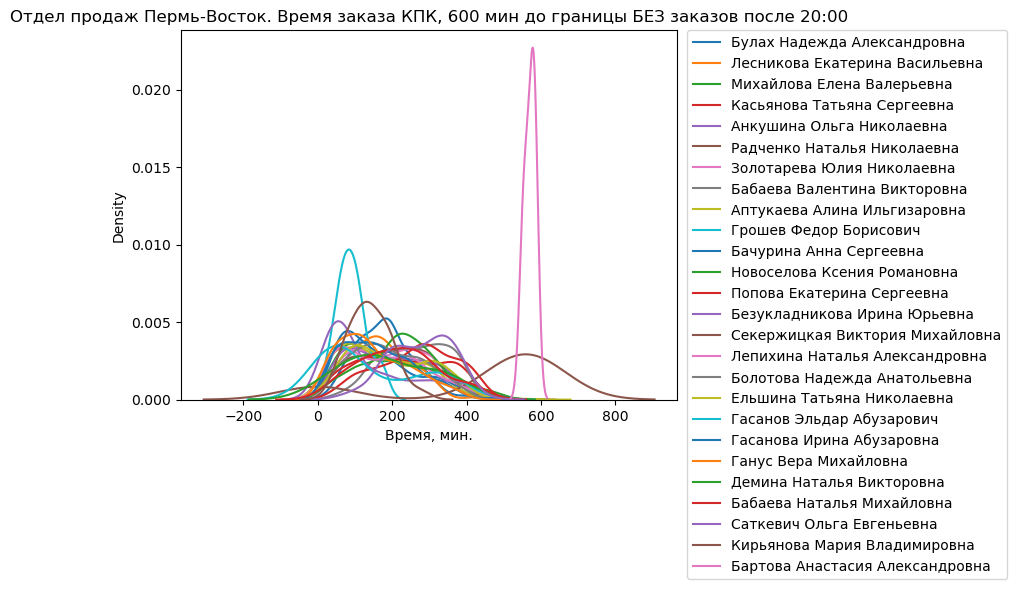

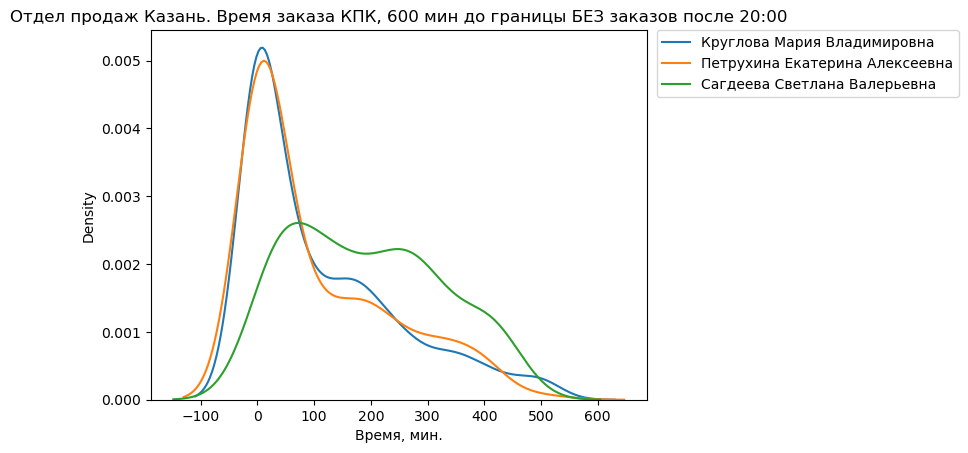

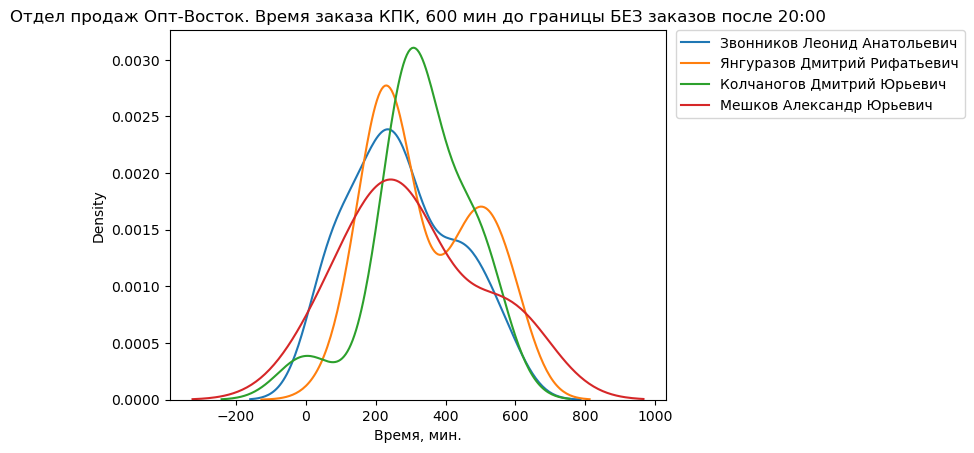

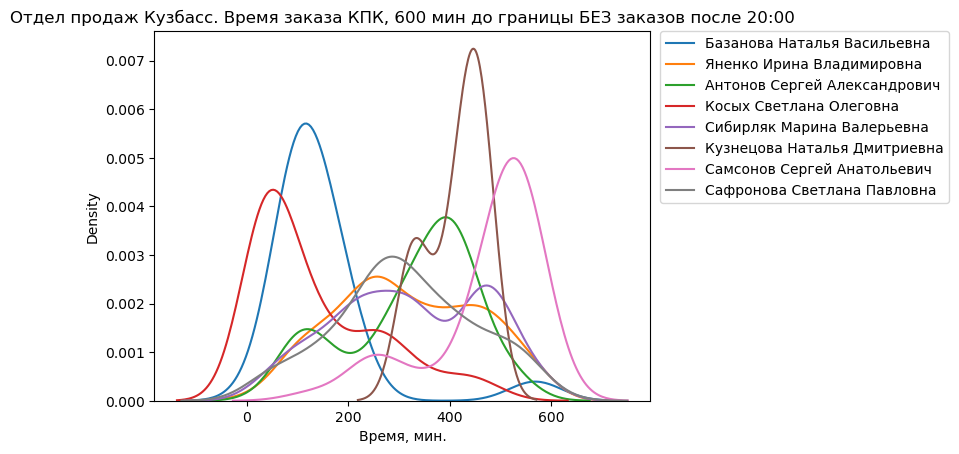

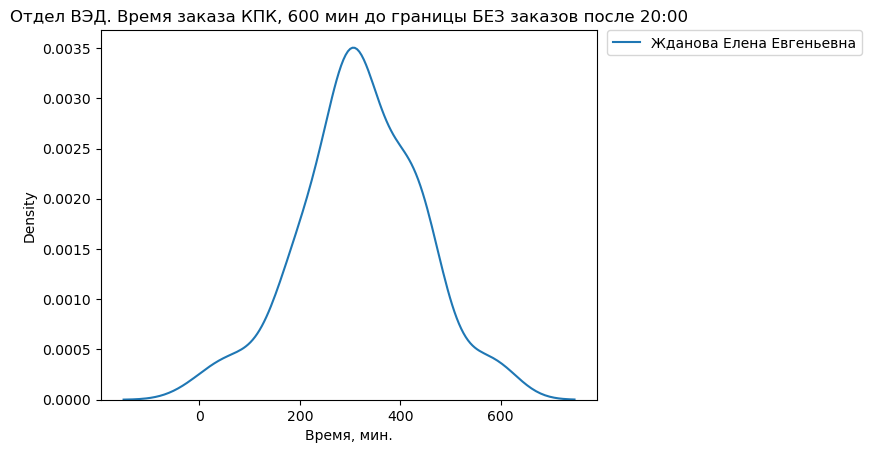

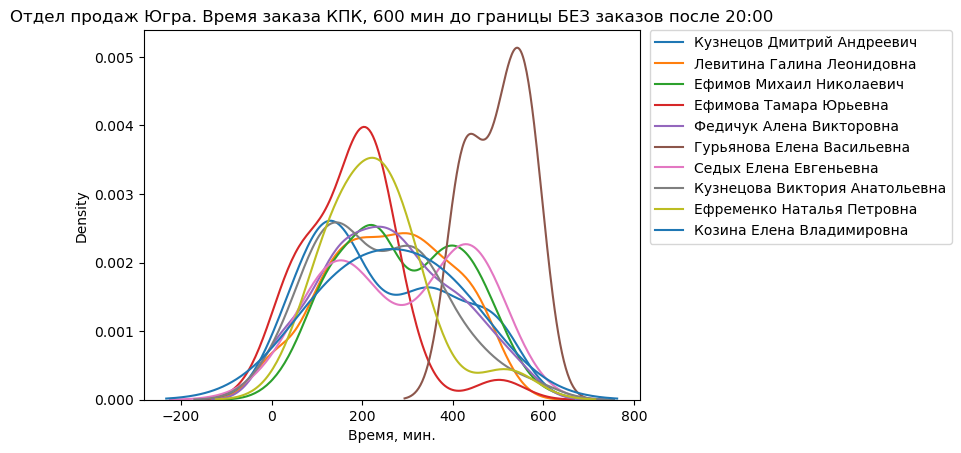

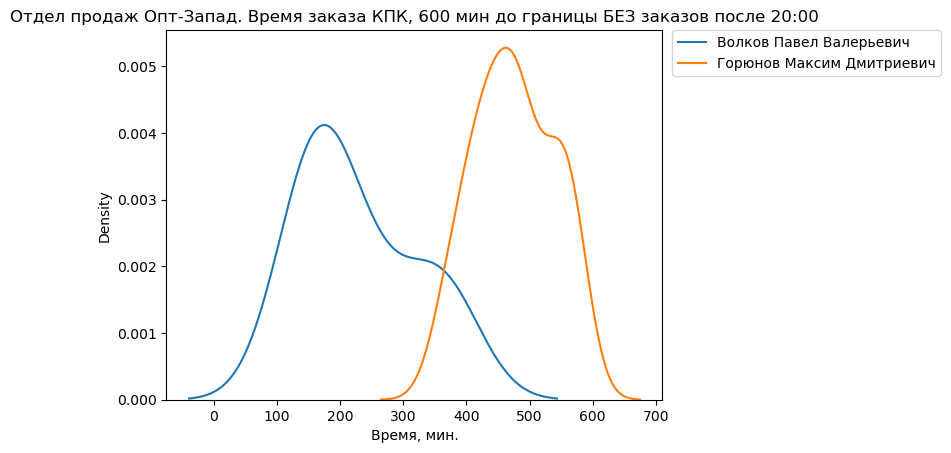

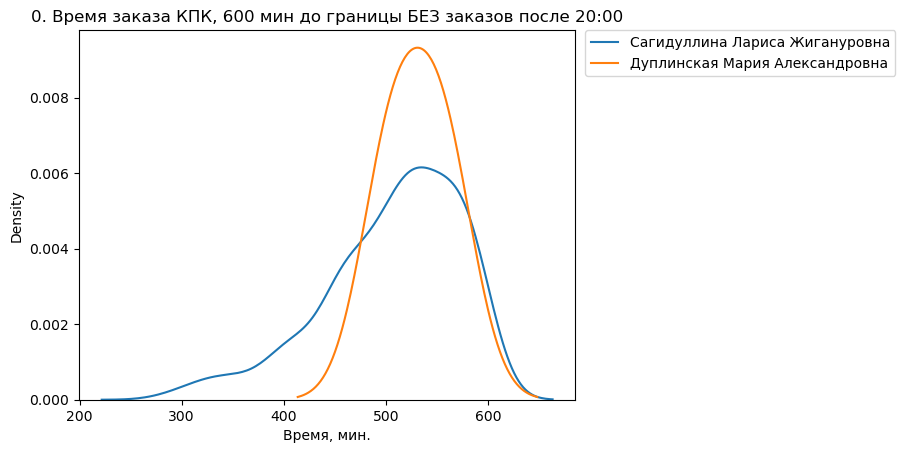

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


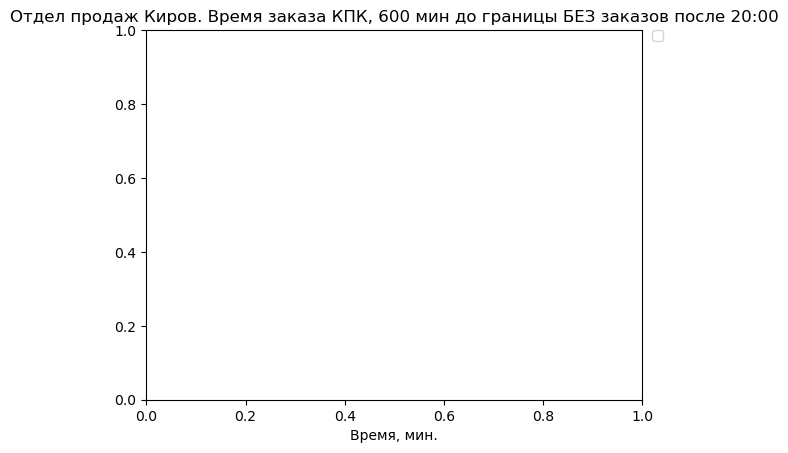

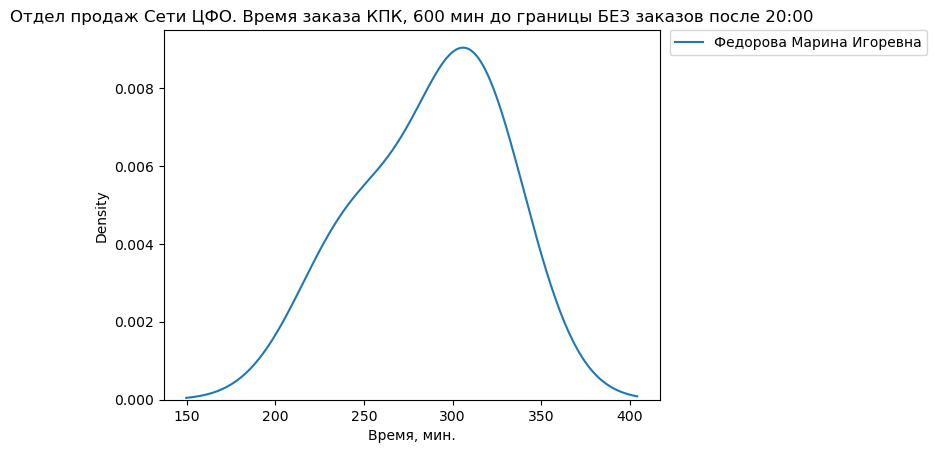

In [136]:
reg = df_orders['region'].unique()

plt.figure(figsize=(7, 5))

for j in range(len(reg)):
    reg_users = df_orders[df_orders['region']==reg[j]]['user'].unique()

    for i in range(len(reg_users)):
        sns.kdeplot(df_orders[(df_orders['user']==reg_users[i])
                          &(df_orders['phon_to_bord']<600)
                          &(df_orders['hour_bord']<=20)]['phon_to_bord'], label=reg_users[i], warn_singular=False)

    plt.xlabel("Время, мин.")
    plt.title(f'{reg[j]}. Время заказа КПК, 600 мин до границы БЕЗ заказов после 20:00')
    plt.legend(bbox_to_anchor=(1.02 , 1), loc='upper left', borderaxespad= 0)
    plt.show()



### Выявить сотрудников, которые дают заказы чаще всего

- создать новый датасет из трех колонок - ОП, ТП и дата Мелафона по Уральскому времени
- преобразовать дату КПК в формате дата/время
- выделяется отдельный столбец с датой
- провести сортировку по всем столбцам
- для каждого ТП в дату найти минимальное время заказа
- создать столбец с последующим значением времени
- создать столбец с разницей текущего и минимального времени и удалить строки с нулевым значением
- вычислить время между заказами и удалить технические столбцы
- разделить интервалы на категории и указать % каждой категории
- создать обобщенный датасет

In [137]:
df_orders.loc[:, ['region', 'user', 'date_melafon_ural']].head(3)

region  \
0                    Отдел продаж Курортное (Озерск)   
1  Отдел продаж Свердловская область Восток (Асбест)   
2           Отдел продаж Средний Урал (Нижний Тагил)   

                             user    date_melafon_ural  
0       Зарипова Дарья Викторовна  2023-02-05 13:23:50  
1  Тимофеева Елизавета Викторовна  2023-02-05 13:16:34  
2      Кузницына Ирина Викторовна  2023-02-05 12:57:17

In [138]:
# Создание файла
df_date_melafon_orders = df_orders.loc[:, ['region', 'user', 'date_melafon_ural']]
df_date_melafon_orders['date_melafon_ural'] = pd.to_datetime(df_date_melafon_orders['date_melafon_ural'], 
                                                             format='%Y-%m-%d %H:%M:%S')
df_date_melafon_orders['just_date_melafon_ural'] = df_date_melafon_orders['date_melafon_ural'].dt.date
df_date_melafon_orders = df_date_melafon_orders.sort_values(by=['region', 'user', 'date_melafon_ural'])
df_date_melafon_orders['min_date_melafon_ural'] = df_date_melafon_orders.groupby(['user', 'just_date_melafon_ural'])['date_melafon_ural'].transform('min')
df_date_melafon_orders['next_date_melafon_ural'] = df_date_melafon_orders['date_melafon_ural'].shift()
df_date_melafon_orders['drop_time'] = df_date_melafon_orders.apply(lambda x: fly_min(x['date_melafon_ural'], x['min_date_melafon_ural']), axis=1)
df_date_melafon_orders = df_date_melafon_orders[df_date_melafon_orders['drop_time']!=0]
df_date_melafon_orders['speed_time_orders'] = df_date_melafon_orders.apply(lambda x: fly_min(x['date_melafon_ural'], x['next_date_melafon_ural']), axis=1)
df_date_melafon_orders = df_date_melafon_orders.drop(['date_melafon_ural', 'just_date_melafon_ural', 'min_date_melafon_ural', 'next_date_melafon_ural', 'drop_time'], axis=1)

In [139]:
# Функция разделения интервалов на категории
def speed_time(speed_time):
    if speed_time < 3:
        return '0_3'
    elif speed_time < 5:
        return '3_5'
    elif speed_time < 10:
        return '5_10'
    return 'all'

In [140]:
# Создание столбца категорий
df_date_melafon_orders = df_date_melafon_orders.sort_values(by=['region', 'user', 'speed_time_orders'])
df_date_melafon_orders['categor_speed_time'] = df_date_melafon_orders['speed_time_orders'].apply(speed_time)
df_date_melafon_orders.head(3)

region                            user  speed_time_orders  \
71716      0  Дуплинская Мария Александровна                 14   
71677      0  Дуплинская Мария Александровна                 35   
71887      0  Дуплинская Мария Александровна                 38   

      categor_speed_time  
71716                all  
71677                all  
71887                all

In [141]:
# Создание технического датасета со столбцами дискретного списка
df_date_orders_pivot = df_date_melafon_orders.pivot_table(index=['region', 'user'], columns='categor_speed_time', 
                                         values='speed_time_orders', aggfunc='count')

df_date_orders_pivot = df_date_orders_pivot.reset_index()
df_date_orders_pivot = df_date_orders_pivot.fillna(0)
df_date_orders_pivot.head()

categor_speed_time                       region  \
0                                             0   
1                                             0   
2                                     Отдел ВЭД   
3                   Отдел продаж Алтайский край   
4                   Отдел продаж Алтайский край   

categor_speed_time                            user   0_3   3_5   5_10    all  
0                   Дуплинская Мария Александровна   0.0   0.0    0.0    8.0  
1                   Сагидуллина Лариса Жигануровна  57.0  76.0  121.0  244.0  
2                         Жданова Елена Евгеньевна  15.0  11.0   25.0  131.0  
3                        Ананьев Андрей Викторович  14.0  12.0   22.0  196.0  
4                        Гостяев Александр Юрьевич   0.0   1.0    1.0    0.0

In [142]:
# Группировка
df_speed_time_orders = df_date_melafon_orders.groupby(['region', 'user']).agg({'speed_time_orders': ['mean', 'median', 'count']})
df_speed_time_orders = df_speed_time_orders.reset_index()
df_speed_time_orders.columns = ['region', 'user', 'speed_time_mean', 'speed_time_median', 'speed_time_count']

df_reg_speed_orders = df_date_melafon_orders.groupby('region').agg({'speed_time_orders': ['mean', 'median', 'count']})
df_reg_speed_orders = df_reg_speed_orders.reset_index()
df_reg_speed_orders.columns = ['region', 'speed_time_mean', 'speed_time_median', 'speed_time_count']


In [143]:
# Добавление дискретного списка к исходному сгруппированному файлу
df_speed_time_orders = df_speed_time_orders.merge(df_date_orders_pivot, on=['region', 'user'], how='left')

In [144]:
# Расчет процента повторений категорий дискретного списка
categor_list = ['0_3', '3_5', '5_10', 'all']
new_categor_list = ['pers_0_3', 'pers_3_5', 'pers_5_10', 'pers_all']

for i in range(len(categor_list)):
    df_speed_time_orders[categor_list[i]] = df_speed_time_orders[categor_list[i]].astype(int)
    df_speed_time_orders[new_categor_list[i]] = df_speed_time_orders[categor_list[i]] / df_speed_time_orders['speed_time_count'] * 100
    df_speed_time_orders[new_categor_list[i]] = df_speed_time_orders[new_categor_list[i]].astype(int)

In [145]:
df_speed_time_orders.head(2)

region                            user  speed_time_mean  speed_time_median  \
0      0  Дуплинская Мария Александровна        58.750000               53.0   
1      0  Сагидуллина Лариса Жигануровна        19.993976                9.0   

   speed_time_count  0_3  3_5  5_10  all  pers_0_3  pers_3_5  pers_5_10  \
0                 8    0    0     0    8         0         0          0   
1               498   57   76   121  244        11        15         24   

   pers_all  
0       100  
1        48

In [146]:
df_reg_speed_orders.head()

region  speed_time_mean  speed_time_median  \
0                                0        20.606719                9.0   
1                        Отдел ВЭД        61.538462               28.0   
2      Отдел продаж Алтайский край        30.143864               13.0   
3  Отдел продаж Башкортостан Север        33.983007               16.0   
4    Отдел продаж Башкортостан Уфа        30.610888               11.0   

   speed_time_count  
0               506  
1               182  
2              2412  
3              5473  
4              4721

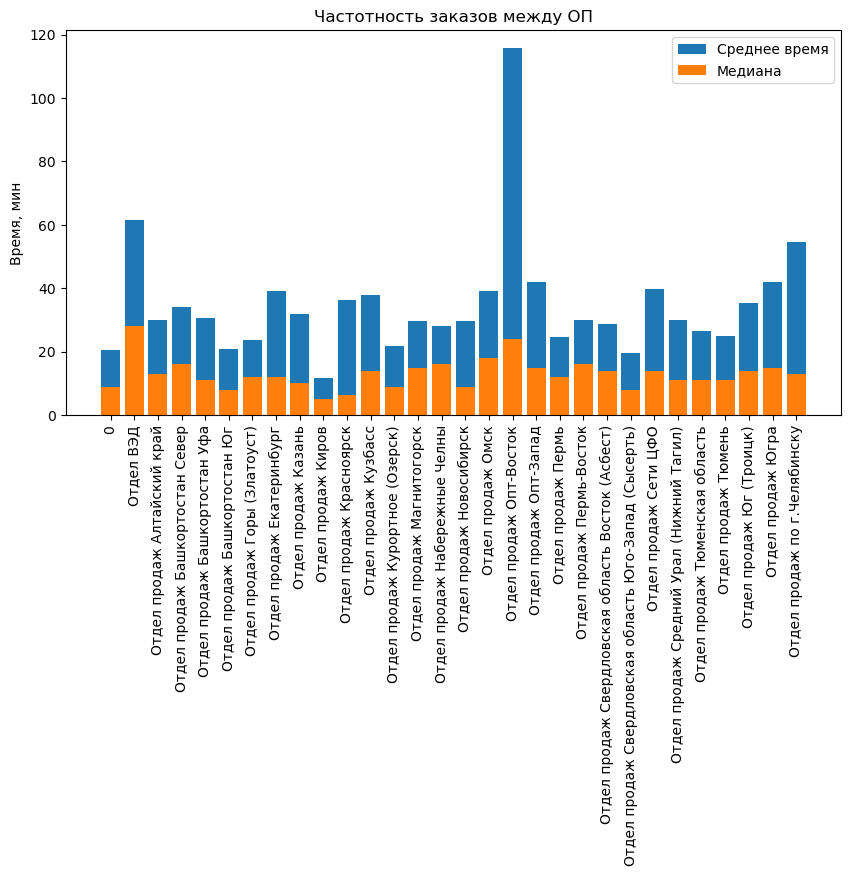

In [147]:
plt.subplots(figsize=(10, 5))

plt.bar(x=df_reg_speed_orders['region'], 
        height=df_reg_speed_orders['speed_time_mean'], label='Среднее время')

plt.bar(x=df_reg_speed_orders['region'], 
        height=df_reg_speed_orders['speed_time_median'], label='Медиана')

plt.title("Частотность заказов между ОП")
plt.ylabel("Время, мин")
plt.legend()
plt.tick_params(axis='x', labelrotation = 90)

plt.show()

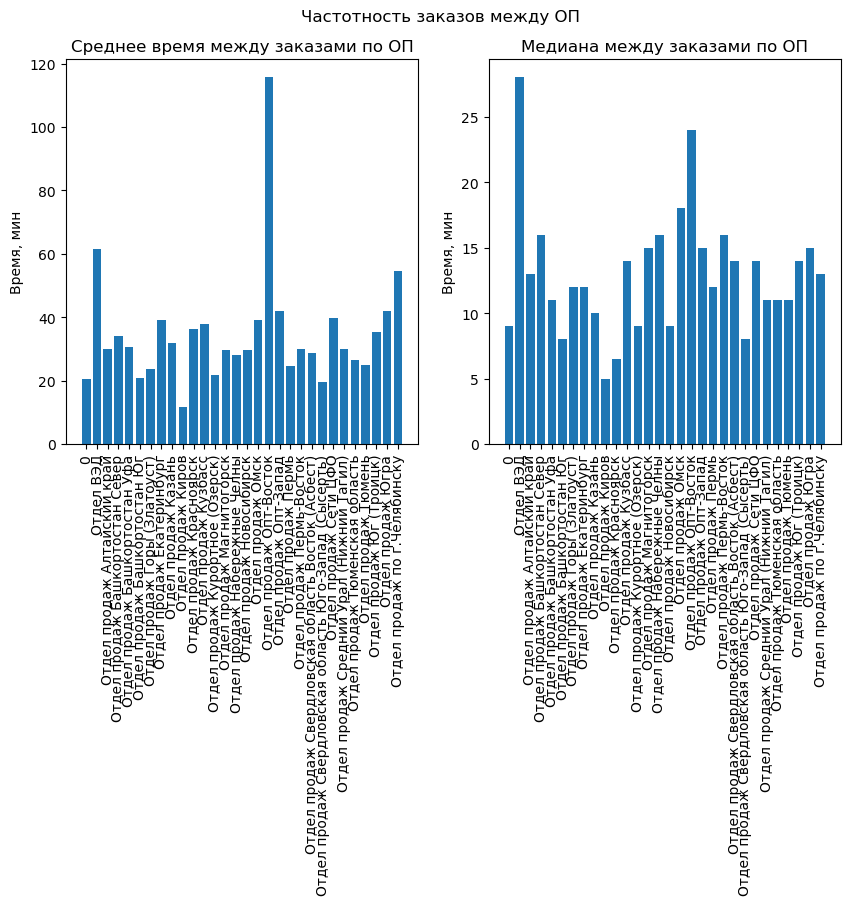

In [148]:
# График времени между заказами
f, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].bar(x=df_reg_speed_orders['region'], 
        height=df_reg_speed_orders['speed_time_mean'])
axs[0].set_title("Среднее время между заказами по ОП")
axs[0].set_ylabel("Время, мин")
axs[0].tick_params(axis='x', labelrotation = 90)

axs[1].bar(x=df_reg_speed_orders['region'], 
        height=df_reg_speed_orders['speed_time_median'])
axs[1].set_title("Медиана между заказами по ОП")
axs[1].set_ylabel("Время, мин")
axs[1].tick_params(axis='x', labelrotation = 90)

plt.suptitle("Частотность заказов между ОП")
plt.show()

## Выводы

Проведенный анализ показал, что основной перекос ритмичной работы склада возникает вследствие выраженного диссонанса между временными пиками нагрузки поступления заказов и их комплектации/сборки. Основной объем поступления заказов приходится на середину дня, тогда как, наименьшая нагрузка на склад приходится на первую половину дня.

Карта плотности распределения заказов показала, взрывной рост нагрузки ежедневно по будням, особенно в пятницу, с 15 часов.

При этом нет проблемы в скорости передачи заказа, скорости его обработки или сборки. Эти операции проходят ритмично и быстро. 

Есть связь с временем создания заказов и ритмичностью работы склада по их сборки. Чем ближе время к середине дня, тем меньше вероятность оперативной сборки поступившего заказа. Проблема заключается в том, что основной список границ запрета отгрузки также приходится на середину дня по Уральскому времени. В попытке максимизировать заказ, торговые представители стремятся подать заказ в самый последний момент, что подтверждено объемом заказов (как в стоимостном, так и в объемном выражении) создаваемых в последний час до границы запрета заказа.

Данное поведение персонала может быть еще и связано с нежеланием или невозможностью формировать и отправлять заказ из торговой точки контрагента – неудобный интерфейс, отсутствие интернета, низкий уровень подготовки сотрудника. 

Анализ времени формирования заказов, позволил выявить подразделения и торговых представителей, систематически создающих заказы в последний час до границы запрета. 

Однако, для системного решения проблемы требуется полный пересмотр графика границ запрета заказа. Распределение должно быть сделано более плавным, а границу запрета заказов необходимо распределить более равномерно в течении дня.
